# Bibliotécas

In [264]:
# Utilitários
import pandas as pd
import numpy as np
from datetime import datetime

# Visualização estática
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e transformações
from sklearn.preprocessing import (StandardScaler,
                                   FunctionTransformer,
                                   OneHotEncoder,
                                   OrdinalEncoder)

# Redução de dimensionalidade
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Modelagem
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

# Hierarchical utils
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Métricas
from sklearn.metrics import silhouette_score, silhouette_samples

# Modelos auxiliares
from sklearn.ensemble import RandomForestRegressor

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Visualizadores Yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Ferramentas úteis de plotting
from matplotlib.gridspec import GridSpec
from IPython.display import HTML
from ipywidgets import interact

# Misc: string manip, etc.
import string

# Configurações estéticas
sns.set(style = 'whitegrid')
plt.rcParams['figure.dpi'] = 120

# Biblioteca padrão
import warnings
warnings.filterwarnings('ignore')

# Funções

In [265]:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

In [266]:
#from IPython.display import HTML
def jupyter_settings():
    %matplotlib inline
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [20, 9]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container{width: 100% !important;}</style>'))
    
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    # Aumenta a quantidade de texto mostrado nas células de saída
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = 'all'
jupyter_settings()

def dados_faltantes(df):
    faltantes_qtde = df.isna().sum()
    faltantes_perc = df.isna().mean() * 100
    faltantes_df = pd.DataFrame({'Qtde Faltantes': faltantes_qtde,
                                 'Perc Faltantes (%)': faltantes_perc}).sort_values(by = 'Perc Faltantes (%)', ascending = False)
    return faltantes_df.round(2)
    
def linhas_duplicadas(df):
    return (df.groupby(df.columns.tolist(), dropna = False)
              .size()
              .to_frame('qtde_linhas_duplicadas')
              .query('qtde_linhas_duplicadas > 1')
              .sort_values('qtde_linhas_duplicadas', ascending = False))

def descricao_estatistica_variaveis(df, tipo = 'num'):
    if tipo == 'num':        
        variaveis_numericas = df.select_dtypes(include = ['number']) # Seleção de variáveis numéricas
        if variaveis_numericas.empty:
            return 'Não há variáveis numéricas no DataFrame.'        
        metricas = pd.DataFrame({'min': variaveis_numericas.min(),
                                 'max': variaveis_numericas.max(),
                                 'amplitude': variaveis_numericas.max() - variaveis_numericas.min(),
                                 'mean': variaveis_numericas.mean(),
                                 'median': variaveis_numericas.median(),
                                 'std': variaveis_numericas.std(),
                                 'assimetria': variaveis_numericas.skew(),
                                 'kurtosis': variaveis_numericas.kurtosis()})
        return metricas.T    
    elif tipo == 'cat': # Seleção de variáveis categóricas        
        variaveis_categoricas = df.select_dtypes(include = ['object', 'category'])
        if variaveis_categoricas.empty:
            return 'Não há variáveis categóricas no DataFrame.'
        metricas_categoricas = pd.DataFrame({'coluna': variaveis_categoricas.columns,
                                             'valores_unicos': [variaveis_categoricas[col].nunique() for col in variaveis_categoricas.columns]})
        return metricas_categoricas
    else:
        return "O parâmetro 'tipo' deve ser 'num' ou 'cat'."

def analise_variancia(df):
    numericas = df.select_dtypes(include = ['number'])
    categoricas = df.select_dtypes(exclude = ['number'])
    
    if not numericas.empty:
        print('Variância das variáveis numéricas:')
        variancias = numericas.var()
        variancias_sorted = variancias.sort_values(ascending = False)
        
        with pd.option_context('display.float_format', '{:f}'.format):
            print(variancias_sorted.to_string(float_format=lambda x: f"{x:,.0f}" if x >= 1 else f"{x:.8f}"))
    
    if not categoricas.empty:
        print('\nNúmero de valores únicos nas variáveis categóricas:')
        print(categoricas.nunique())

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados
##### O objetivo deste passo é ter um entendimento inicial de como os dados estão relacionados com o problema de negócio proposto.

### 1.1 Descrição do desafio

* Neste projeto, será realizada uma clusterização não supervisionada de dados dos registros de clientes de um banco de dados de uma empresa de alimentos. A segmentação de clientes consiste na prática de separar os clientes em grupos que refletem similaridades entre os clientes em cada cluster. Os clientes serão divididos em segmentos para otimizar a importância de cada cliente para o negócio. O objetivo é modificar os produtos de acordo com as necessidades e comportamentos distintos dos clientes. Essa abordagem também auxilia a empresa a atender às necessidades de diferentes tipos de clientes.

fonte: https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering/notebook

#### 1.1.1 Descrição das colunas (dicionário de dados)

**ID** – Identificador único do cliente

**Year_Birth** - Ano de nascimento do cliente

**Education** - Nível educacional

**Marital_Status** – Estado civil

**Income** - Renda anual do cliente

**Kidhome** - Número de crianças em casa

**Teenhome** - Número de adolescentes em casa

**Dt_Customer** - Data de cadastro do cliente 

**Recency** – Número de dias desde a última compra

**MntWines** - Valor gasto em vinhos nos últimos 2 anos

**MntFruits** - Valor gasto em frutas nos últimos 2 anos

**MntMeatProducts** - Valor gasto em carnes nos últimos 2 anos

**MntFishProducts** - Valor gasto em peixes nos últimos 2 anos

**MntSweetProducts** - Valor gasto em doces nos últimos 2 anos

**MntGoldProds** - Valor gasto em produtos premium nos últimos 2 anos

**NumDealsPurchases** - Número de compras com descontos

**NumWebPurchases** - Número de compras realizadas via website

**NumCatalogPurchases** - Número de compras realizadas via catálogo

**NumStorePurchases** - Número de compras realizadas na loja física

**NumWebVisitsMonth** - Número de visitas ao website no último mês

**AcceptedCmp1** - Aceitou a campanha 1 (1 = Sim, 0 = Não)

**AcceptedCmp2** - Aceitou a campanha 2 (1 = Sim, 0 = Não)

**AcceptedCmp3** - Aceitou a campanha 3 (1 = Sim, 0 = Não)

**AcceptedCmp4** - Aceitou a campanha 4 (1 = Sim, 0 = Não)

**AcceptedCmp5** - Aceitou a campanha 5 (1 = Sim, 0 = Não)

**Complain** - Registrou reclamação nos últimos 2 anos (1 = Sim, 0 = Não)

**Z_CostContact** - Custo de contato

**Z_Revenue** - Receita (provavelmente constante)

**Response** - Respondeu à última campanha (1 = Sim, 0 = Não)

### 1.2 Carregar os dados

In [267]:
df = pd.read_csv('../dataset/marketing_campaign.csv', sep = "\t") # O arquivo é um TSV (Tab-Separated Values) em vez de CSV

### 1.3 Copia dos dados

In [268]:
df1 = df.copy()

### 1.3.1 Conhecer os dados

In [269]:
df.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0


### 1.4 Dimensão dos dados

In [270]:
print('Tamanho da tabela de dados:', df1.shape)

Tamanho da tabela de dados: (2240, 29)


### 1.5 Verificar NA's

In [271]:
dados_faltantes(df1).head(3)

,Qtde Faltantes,Perc Faltantes (%)
Income,24,1.07
ID,0,0.00
Year_Birth,0,0.00


* Existe 1 coluna que apresentavam dados faltantes: 'Income', como não tenho informações suficientes para compreender os motivos destes NAN, optei inicialmente por removê-las do dataset, mesmo por que a quantidade destes dados faltantes é baixa. Caso necessário em etapas posteriores, uma alternativa seria realizar a imputação desses valores por meio de algoritmos de regressão e classificação.

### 1.5.1 Tratar NA's

In [272]:
df1 = df1.dropna(subset = 'Income').reset_index(drop = True)

In [273]:
dados_faltantes(df1).head(3)

,Qtde Faltantes,Perc Faltantes (%)
ID,0,0.0
Year_Birth,0,0.0
Education,0,0.0


In [274]:
print('Agora o tamanho da tabela de dados:', df1.shape)

Agora o tamanho da tabela de dados: (2216, 29)


### 1.5.2 Alterar nome colunas

In [275]:
df1.rename(columns = {'ID': 'id',
                      'Year_Birth': 'ano_nascimento',
                      'Education': 'educacao',
                      'Marital_Status': 'estado_civil',
                      'Income': 'renda',
                      'Kidhome': 'qtde_criancas',
                      'Teenhome': 'qtde_adolescentes',
                      'Dt_Customer': 'data_cadastro',
                      'Recency': 'dias_ultima_compra',
                      'MntWines': 'valor_gasto_vinhos',
                      'MntFruits': 'valor_gasto_frutas',
                      'MntMeatProducts': 'valor_gasto_carnes',
                      'MntFishProducts': 'valor_gasto_peixes',
                      'MntSweetProducts': 'valor_gasto_doces',
                      'MntGoldProds': 'valor_gasto_premium',
                      'NumDealsPurchases': 'qtde_compras_descontos',
                      'NumWebPurchases': 'qtde_compras_website',
                      'NumCatalogPurchases': 'qtde_compras_catalogo',
                      'NumStorePurchases': 'qtde_compras_loja_fisica',
                      'NumWebVisitsMonth': 'qtde_visitas_website',
                      'AcceptedCmp3': 'aceitou_campanha_3',
                      'AcceptedCmp4': 'aceitou_campanha_4',
                      'AcceptedCmp5': 'aceitou_campanha_5',
                      'AcceptedCmp1': 'aceitou_campanha_1',
                      'AcceptedCmp2': 'aceitou_campanha_2',
                      'Complain': 'registrou_reclamaçao',
                      'Z_CostContact': 'custo_contrato',
                      'Z_Revenue': 'receita',
                      'Response': 'respondeu_campanha'}, inplace = True)

In [276]:
df1.head(3)

,id,ano_nascimento,educacao,estado_civil,renda,qtde_criancas,qtde_adolescentes,data_cadastro,dias_ultima_compra,valor_gasto_vinhos,valor_gasto_frutas,valor_gasto_carnes,valor_gasto_peixes,valor_gasto_doces,valor_gasto_premium,qtde_compras_descontos,qtde_compras_website,qtde_compras_catalogo,qtde_compras_loja_fisica,qtde_visitas_website,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,aceitou_campanha_1,aceitou_campanha_2,registrou_reclamaçao,custo_contrato,receita,respondeu_campanha
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0


### 1.5.3 Reorganizar as colunas

In [277]:
df1 = df1[['id',
           'ano_nascimento',
           'educacao',
           'estado_civil', 
           'renda',
           'qtde_criancas', 
           'qtde_adolescentes', 
           'data_cadastro',
           'dias_ultima_compra', 
           'valor_gasto_vinhos', 
           'valor_gasto_frutas',
           'valor_gasto_carnes', 
           'valor_gasto_peixes', 
           'valor_gasto_doces',
           'valor_gasto_premium', 
           'qtde_compras_descontos', 
           'qtde_compras_website',
           'qtde_compras_catalogo', 
           'qtde_compras_loja_fisica',
           'qtde_visitas_website', 
           'aceitou_campanha_1', 
           'aceitou_campanha_2',
           'aceitou_campanha_3', 
           'aceitou_campanha_4',
           'aceitou_campanha_5', 
           'respondeu_campanha',
           'registrou_reclamaçao', 
           'custo_contrato', 
           'receita']]

### 1.6 Tipo de dados

In [278]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2216 non-null   int64  
 1   ano_nascimento            2216 non-null   int64  
 2   educacao                  2216 non-null   object 
 3   estado_civil              2216 non-null   object 
 4   renda                     2216 non-null   float64
 5   qtde_criancas             2216 non-null   int64  
 6   qtde_adolescentes         2216 non-null   int64  
 7   data_cadastro             2216 non-null   object 
 8   dias_ultima_compra        2216 non-null   int64  
 9   valor_gasto_vinhos        2216 non-null   int64  
 10  valor_gasto_frutas        2216 non-null   int64  
 11  valor_gasto_carnes        2216 non-null   int64  
 12  valor_gasto_peixes        2216 non-null   int64  
 13  valor_gasto_doces         2216 non-null   int64  
 14  valor_ga

### 1.6.1 Editar os tipos de dados

In [279]:
df1['id'] = df1['id'].astype('object')
df1['data_cadastro'] = pd.to_datetime(df1['data_cadastro'], dayfirst = True, errors = 'coerce') # Usar dayfirst = True pois o formato da data é %d-%m-%Y

### 1.7 Verificar valores duplicados

In [280]:
linhas_duplicadas(df1)

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,qtde_linhas_duplicadas
id,ano_nascimento,educacao,estado_civil,renda,qtde_criancas,qtde_adolescentes,data_cadastro,dias_ultima_compra,valor_gasto_vinhos,valor_gasto_frutas,valor_gasto_carnes,valor_gasto_peixes,valor_gasto_doces,valor_gasto_premium,qtde_compras_descontos,qtde_compras_website,qtde_compras_catalogo,qtde_compras_loja_fisica,qtde_visitas_website,aceitou_campanha_1,aceitou_campanha_2,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,respondeu_campanha,registrou_reclamaçao,custo_contrato,receita,


### 1.8 Descrição estatística do negócio

In [281]:
descricao_estatistica_variaveis(df1, 'num').T

,min,max,amplitude,mean,median,std,assimetria,kurtosis
ano_nascimento,1893.0,1996.0,103.0,1968.820397,1970.0,11.985554,-0.353661,0.734670
renda,1730.0,666666.0,664936.0,52247.251354,51381.5,25173.076661,6.763487,159.636700
qtde_criancas,0.0,2.0,2.0,0.441787,0.0,0.536896,0.635610,-0.791164
qtde_adolescentes,0.0,2.0,2.0,0.505415,0.0,0.544181,0.407553,-0.989619
dias_ultima_compra,0.0,99.0,99.0,49.012635,49.0,28.948352,0.001648,-1.199777
valor_gasto_vinhos,0.0,1493.0,1493.0,305.091606,174.5,337.327920,1.170720,0.582741
valor_gasto_frutas,0.0,199.0,199.0,26.356047,8.0,39.793917,2.101658,4.054082
valor_gasto_carnes,0.0,1725.0,1725.0,166.995939,68.0,224.283273,2.025577,5.055477
valor_gasto_peixes,0.0,259.0,259.0,37.637635,12.0,54.752082,1.916369,3.076476
valor_gasto_doces,0.0,262.0,262.0,27.028881,8.0,41.072046,2.103328,4.106141


* Algumas observações: 

* A variável 'ano_nascimento' tem média de 1969 e mediana de 1970
    (2025 - 1969 = 56 e 2025 - 1970 = 55), ou seja adultos de meia idade com valores entre 55 à 56 anos.o desvio padrão de 11,99 isso em idade seria algo entre 56 +/- 11,99 = 44-68 anos. Sobre a amplitude, verificamos que o valor min de 1893 até os dias atuais o individuo teria 132 anos, ou seja, possivelmente um outliers a ser verificado.
    Base com consumidores mais velhos, tendência ao público 45–70 anos.
    Possível impacto no comportamento de compra optando por por loja física, catálogo (canal tradicional) e maior propensão de comprar produtos premium (maior poder aquisitivo ou preferência por qualidade)

* A variável 'renda' tem média de 52.247 e mediana de 51.381
    Distribuição altamente concentrada em rendas baixas/médias
    Alguns outliers absurdos de renda muito alta puxando a média e possivelmente será necessário tratamento destes outliers

* A variável 'qtde_criancas' tem mediana igual a 0
    Evidênciando que a maioria dos casais não tem filhos e um pequeno grupo com 1 ou 2 filhos

* A variável 'aceitou_campanha (1-5)' tem mediana igual a 0
    Indicando baixa efetividade das campanhas atuais, talvez campanhas genéricas sem segmentação evidênciando necessidade de personalização.

* As variáveis 'custo_contato' e 'receita', são constantes
    Estas variáveis não tem variabilidade, ou sejam, não agregam valor para os modelos, possivelmente serão removidas posteriormente.

In [282]:
descricao_estatistica_variaveis(df1, 'cat')

,coluna,valores_unicos
0,id,2216
1,educacao,5
2,estado_civil,8


* A variável 'educacao' tem 5 tipos de dados

'Basic' - Ensino fundamental

'2n Cycle' - Ensino médio

'Graduation' - Graduação

'Master' - Pós-graduação

'PhD' - Doutorado

* A variável 'estado_civil' tem 8 tipos de dados

'Single' - Solteiro

'Together' - União estável

'Married' - Casado

'Divorced' - Divorciado

'Widow' - Viúvo

'Alone' - ?

'Absurd' - ?

'YOLO' - ?

* As categorias 'Together' e 'Married' serão agrupadas para facilitar as análises, bem como as categorias 'Single', 'Alone' e 'YOLO', já a categoria 'Absurd' possivelmente será tratadas posteriormente.

### 1.9 Analise variância univariada

In [283]:
analise_variancia(df1)

Variância das variáveis numéricas:
renda                      633,683,789
valor_gasto_vinhos             113,790
valor_gasto_carnes              50,303
valor_gasto_peixes               2,998
valor_gasto_premium              2,685
valor_gasto_doces                1,687
valor_gasto_frutas               1,584
dias_ultima_compra                 838
ano_nascimento                     144
qtde_compras_loja_fisica            11
qtde_compras_catalogo                9
qtde_compras_website                 8
qtde_visitas_website                 6
qtde_compras_descontos               4
qtde_adolescentes           0.29613319
qtde_criancas               0.28825757
respondeu_campanha          0.12774710
aceitou_campanha_4          0.06856109
aceitou_campanha_3          0.06817624
aceitou_campanha_5          0.06779099
aceitou_campanha_1          0.06000033
aceitou_campanha_2          0.01336066
registrou_reclamaçao        0.00939097
custo_contrato              0.00000000
receita                     0

* A variância é uma medida estatística que indica o quanto os valores de uma variável se dispersam em relação à sua média, ou seja, mostra o quanto aquela variável varia entre os indivíduos do conjunto de dados
    * Variância alta → a variável muda bastante → tem maior capacidade de diferenciá-los.
    * Variância baixa → os valores são muito parecidos → a variável tem pouco poder de separação
    * Variância zero → todos os registros têm o mesmo valor → a variável não traz informação útil e deve ser removida.

# 2. (Limpeza dos dados) Passo 2: Engenharia de variáveis
##### Neste passo serão criadas hipóteses relativas ao negócio e também se necessário, poderão ser criadas novas variáveis a partir das variáveis originais a fim de melhorar a qualidade dos dados facilitando seu o entendimento.

### 2.1 Copia dos dados

In [284]:
df2 = df1.copy()

### 2.2 Hipóteses relacionadas ao negócio

**1.** Clientes com maior renda gastam mais no total?

**2.** Clientes com maior renda gastam proporcionalmente mais em produtos premium e vinhos?

**3.** Clientes com filhos compram mais frequentemente que clientes sem filhos?

**4.** Quanto maior o tempo desde a última compra (R), menor o valor gasto?

**5.** Clientes que já aceitaram uma campanha têm maior probabilidade de aceitar outras?

**6.** Clientes com maior nível educacional possuem maior gasto médio?

**7.** Clientes casados compram mais que clientes solteiros?

**8.** Clientes com alta recência (muito tempo sem comprar) têm baixa resposta a campanhas?

**9.** Clientes que compram vinhos tendem a comprar carnes?

**10.** Clientes que compram com desconto gastam menos no total?

**11.** Alta renda não significa maior gasto?

**12.** Clientes digitais respondem menos a campanhas?

### 2.3 Derivar as variáveis a partir das variáveis originais

In [285]:
df2 = df2.drop(columns = ['custo_contrato', 'receita'], errors = 'ignore')

* Conforme identificado na análise de variância univariada, as variáveis 'custo_contrato' e 'receita' apresentaram variância igual a zero. Por esse motivo, serão removidas do dataset, pois não adicionam informação útil ao modelo

In [286]:
educacao_mapping = {'Basic': 'Basic',
                    '2n Cycle': '2n Cycle', 
                    'Graduation': 'Graduation',
                    'Master': 'Master',
                    'PhD': 'PhD'}

estado_civil_mapping = {'Single': 'Single',
                        'Together': 'Married', 
                        'Married': 'Married',
                        'Divorced': 'Divorced',
                        'Widow': 'Widow',
                        'Alone': 'Single',
                        'Absurd': 'Unknown',
                        'YOLO': 'Single'}

df2['educacao_agrupado'] = df2['educacao'].map(educacao_mapping)
df2['estado_civil_agrupado'] = df2['estado_civil'].map(estado_civil_mapping)

In [287]:
ano_atual = datetime.now().year
df2['idade'] = ano_atual - df2['ano_nascimento']
df2 = df2.loc[df2['idade'] <= 100, :]

* Eliminando as idades maiores que 100 anos

In [288]:
df2['dependentes'] = df2['qtde_criancas'] + df2['qtde_adolescentes']

* Adicionando a coluna 'dependentes' que é a soma da qtde de crianças e adolescentes 

# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio)
##### Nesta etapa, é realizada a filtragem das variáveis com base nas restrições do negócio, ou seja, isso significa verificar se todas as variáveis essenciais estarão disponíveis na base de dados, garantindo que as informações necessárias para o modelo ou análise estejam presentes e possam ser acessadas durante a produção. Essa verificação é crucial para evitar erros futuros e assegurar que o sistema funcione corretamente quando for implementado em um ambiente de produção. Além disso, podemos identificar variáveis redundantes ou irrelevantes, que podem ser removidas para otimizar o desempenho.

### 3.1 Copia dos dados

In [289]:
df3 = df2.copy()

* O dataset utilizado neste estudo contém as seguintes variáveis:

    * Identificação e demografia
        * id, ano_nascimento, educacao, estado_civil, renda

        * qtde_criancas, qtde_adolescentes

    * Informações de cadastro e relacionamento
        
        * data_cadastro, dias_ultima_compra
    
    * Gastos por categoria de produto
    
        * valor_gasto_vinhos, valor_gasto_frutas, valor_gasto_carnes,
    
        * valor_gasto_peixes, valor_gasto_doces, valor_gasto_premium
    
    * Comportamento de compra
    
        * qtde_compras_descontos, qtde_compras_website,
    
        * qtde_compras_catalogo, qtde_compras_loja_fisica
    
        * qtde_visitas_website
    
    * Engajamento com campanhas
    
        * aceitou_campanha_1 a aceitou_campanha_5
    
        * respondeu_campanha, registrou_reclamação
    
    * Informações financeiras
    
        * custo_contato, receita
    
    * Variáveis derivadas
    
        *educacao_agrupado, estado_civil_agrupado

### 3.2 Recencia (R)
##### Quanto menor o número, mais recente o cliente comprou
    dias_ultima_compra

In [290]:
df3['recency'] = df3['dias_ultima_compra']

### 3.3 Frequencia (F)
##### Soma dos totais de compra
    frequency = qtde_compras_descontos
              + qtde_compras_website
              + qtde_compras_catalogo
              + qtde_compras_loja_fisica


In [291]:
df3['frequency'] = df3.filter(like = 'qtde_compras_').sum(axis = 1)

### 3.4 Monetario (M)
##### Soma dos totais de gastos
    monetary = valor_gasto_vinhos
             + valor_gasto_frutas
             + valor_gasto_carnes
             + valor_gasto_peixes
             + valor_gasto_doces
             + valor_gasto_premium

In [292]:
cols_monetary = ['valor_gasto_vinhos',
                 'valor_gasto_frutas',
                 'valor_gasto_carnes',
                 'valor_gasto_peixes',
                 'valor_gasto_doces',
                 'valor_gasto_premium']

df3['monetary'] = df3[cols_monetary].sum(axis = 1)

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados
##### A análise exploratória dos dados (EDA) tem como principal objetivo proporcionar uma compreensão mais aprofundada dos dados, tais como: Compreender a distribuição das variáveis numéricas e categóricas, identificar outliers (valores atípicos), correlações entre as variáveis entre outras análises.

### 4.1 Copia dos dados

In [293]:
df4 = df3.copy()

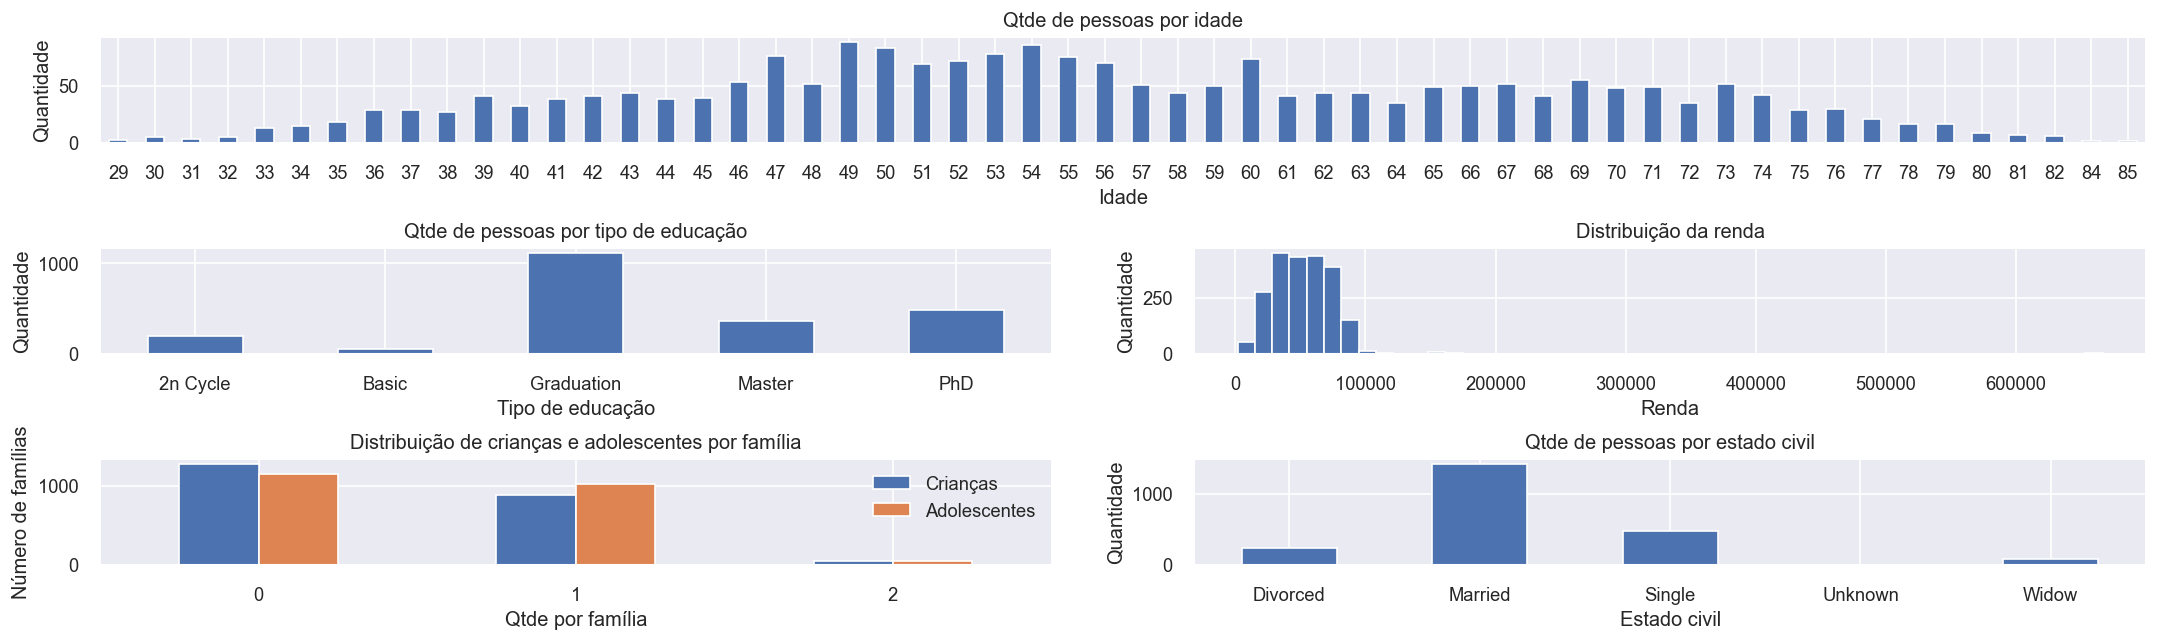

In [294]:
plt.figure(figsize = (22, 8))
grid = plt.GridSpec(4, 2, hspace = 0.99, wspace = 0.15)

plt.subplot(grid[0, :])
df4['idade'].value_counts().sort_index().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.xlabel('Idade')
plt.ylabel('Quantidade')
plt.title('Qtde de pessoas por idade')

plt.subplot(grid[1, 0])
df4['educacao'].value_counts().sort_index().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.xlabel('Tipo de educação')
plt.ylabel('Quantidade')
plt.title('Qtde de pessoas por tipo de educação')

plt.subplot(grid[1, 1])
df4['renda'].plot(kind = 'hist', bins = 50)
plt.xlabel('Renda')
plt.ylabel('Quantidade')
plt.title('Distribuição da renda')

faixa_familia = pd.DataFrame({'Crianças': df4['qtde_criancas'].value_counts().sort_index(),
                              'Adolescentes': df4['qtde_adolescentes'].value_counts().sort_index()})

plt.subplot(grid[2, 0])
faixa_familia.plot(kind = 'bar', ax = plt.gca())
plt.xticks(rotation = 0)
plt.xlabel('Qtde por família')
plt.ylabel('Número de famílias')
plt.title('Distribuição de crianças e adolescentes por família')

plt.subplot(grid[2, 1])
df4['estado_civil_agrupado'].value_counts().sort_index().plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.xlabel('Estado civil')
plt.ylabel('Quantidade')
plt.title('Qtde de pessoas por estado civil')

plt.tight_layout()
plt.show();

* Distribuição da idade, o gráfico mostra claramente um pico entre 49 e 60 anos, indicando um público majoritariamente de meia-idade. Há poucos clientes jovens ou idosos.

* Tipo de educação, a maioria dos clientes tem Graduação, seguido por Master e PhD. O nível Basic tem poucos casos, e 2n Cycle aparece como um intermediário menor.

* Distribuição da renda, a renda é bastante concentrada entre 20.000 e 80.000, com poucos clientes acima de 100.000. Há alguns valores extremos (outliers), mas a grande massa está até 100.000.

* Crianças e adolescentes por família, a maioria das famílias não tem filhos, tanto crianças quanto adolescentes. Entre os que têm, o padrão mais comum é 1 filho e raramente 2.

* Estado civil, a maior parte dos clientes é casada (Married). Após isso aparecem Single e Divorced em proporções menores. A categoria Unknown é pequena e pode indicar dados ausentes.

### 4.1.1 Distribuição do gasto total (Monetary)

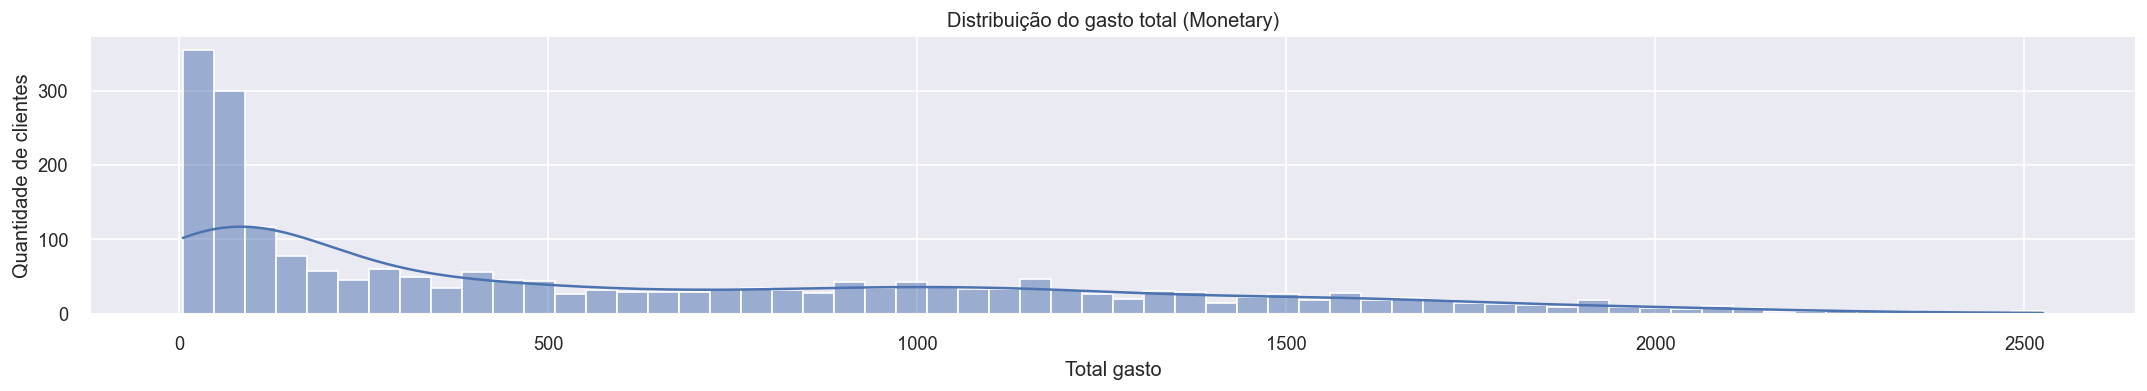

In [295]:
plt.figure(figsize = (22, 3))
sns.histplot(df4['monetary'], bins = 60, kde = True)
plt.title('Distribuição do gasto total (Monetary)')
plt.xlabel('Total gasto')
plt.ylabel('Quantidade de clientes')
plt.show();

* Muitos clientes gastam pouco (concentração à esquerda) e poucos gastam valores muito altos (cauda longa à direita).

### 4.1.2 Distribuição de compras por canal Website × Catálogo × Loja física × Descontos (Frequency)

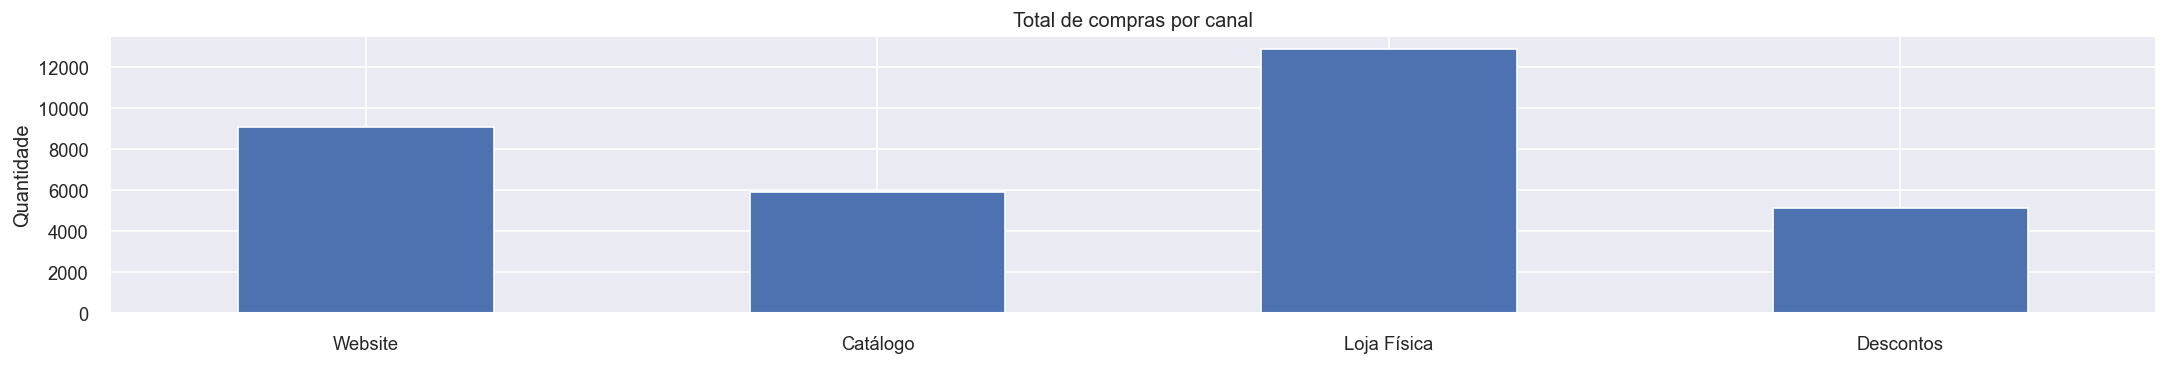

In [296]:
plt.figure(figsize = (22, 3))

compras_por_canal = {'Website': df4['qtde_compras_website'].sum(),
                     'Catálogo': df4['qtde_compras_catalogo'].sum(),
                     'Loja Física': df4['qtde_compras_loja_fisica'].sum(),
                     'Descontos': df4['qtde_compras_descontos'].sum()}

pd.Series(compras_por_canal).plot(kind = 'bar')
plt.title('Total de compras por canal')
plt.ylabel('Quantidade')
plt.xticks(rotation = 0)
plt.show();

* Loja Física é o principal canal de vendas, pois com mais de 12.000 compras, a loja física é claramente o canal dominante. Isso indica:
    * Forte presença do público no ponto físico;
    * Provável preferência por atendimento presencial;
    * Importância estratégica das lojas como principal motor de receita.

* Website é o segundo canal mais relevante, onde cerca de 9.000 compras, o site também é um canal importante.
    * Isso mostra boa digitalização do negócio, embora ainda distante da loja física.

* Catálogo tem desempenho intermediário e compras por Desconto são os menores volumes.

### 4.1.3 Comparação website: visitas × compras

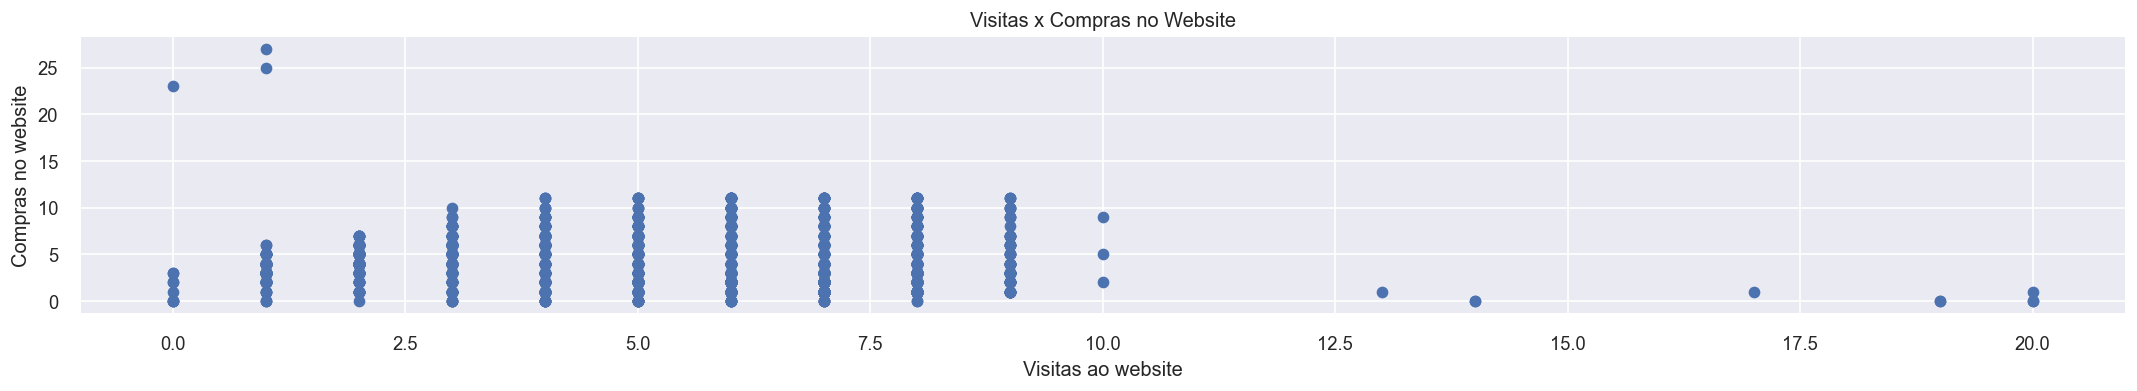

In [297]:
plt.figure(figsize = (22, 3))
plt.scatter(df2['qtde_visitas_website'], df2['qtde_compras_website'])
plt.xlabel('Visitas ao website')
plt.ylabel('Compras no website')
plt.title('Visitas x Compras no Website')
plt.show();

* Não há uma relação linear clara, os pontos estão espalhados de forma bem aleatória, indicando que mais visitas não significa necessariamente mais compras, sugerindo:
    * Baixa conversão digital;
    * Visitas não qualificadas;
    * Usuários navegando sem intenção de compra;
    * Possível problema de usabilidade ou de preços.

* Existem outliers importantes, pois pontos muito altos (ex.: 23, 26 compras) que são exceções possivelmente clientes VIP ou de comportamento atípico.

### 4.1.4 Comparação: idade × total gasto

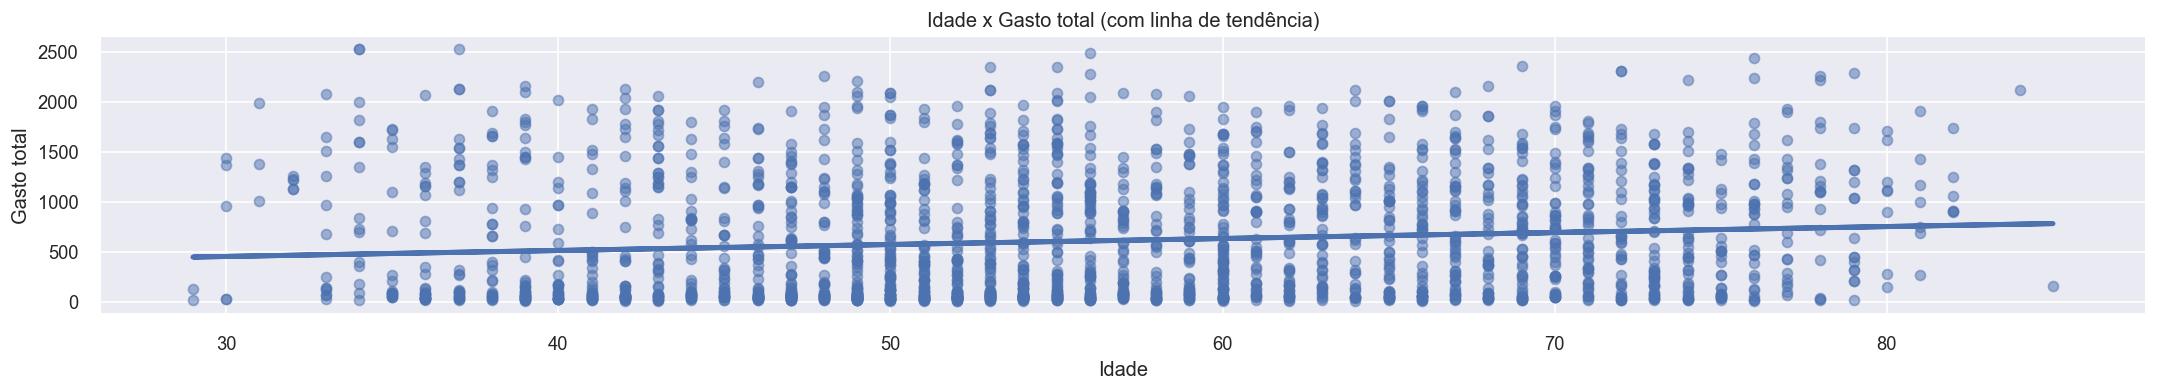

In [298]:
plt.figure(figsize = (22, 3))
plt.scatter(df4['idade'], df4['monetary'], alpha = 0.5)
x = df4['idade']
y = df4['monetary']
coef = np.polyfit(x, y, 1) 
poly1d_fn = np.poly1d(coef)   

plt.plot(x, poly1d_fn(x), linewidth = 3)
plt.xlabel('Idade')
plt.ylabel('Gasto total')
plt.title('Idade x Gasto total (com linha de tendência)')
plt.show();

* O gráfico mostra uma correlação linear positiva, mas extremamente fraca, entre Idade e Gasto total, com a maioria das observações concentradas em baixos valores de Gasto Total, independentemente da idade.

### 4.1.5 Aceitação por campanha

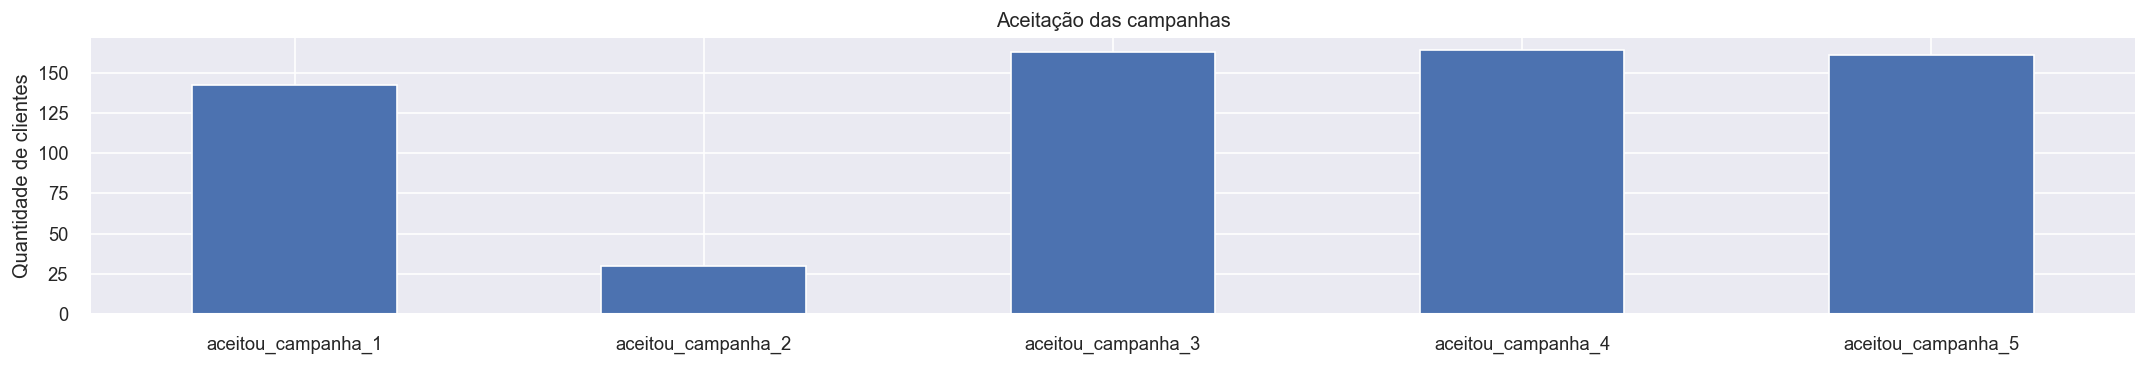

In [299]:
plt.figure(figsize = (22, 3))
campanhas = df4[['aceitou_campanha_1','aceitou_campanha_2','aceitou_campanha_3',
                 'aceitou_campanha_4','aceitou_campanha_5']].sum()
campanhas.plot(kind = 'bar')
plt.title('Aceitação das campanhas')
plt.ylabel('Quantidade de clientes')
plt.xticks(rotation = 0)
plt.show();

* Em relação ao desempenho das campanhas, o gráfico indica que as campanhas 3, 4 e 5 foram as mais bem-sucedidas, enquanto a campanha 2 foi a menos aceita. Essa variabilidade na aceitação é uma informação valiosa para a formação de clusters baseados no comportamento de resposta do cliente.

### 4.1.6 Aceitação: campanha × estado civil

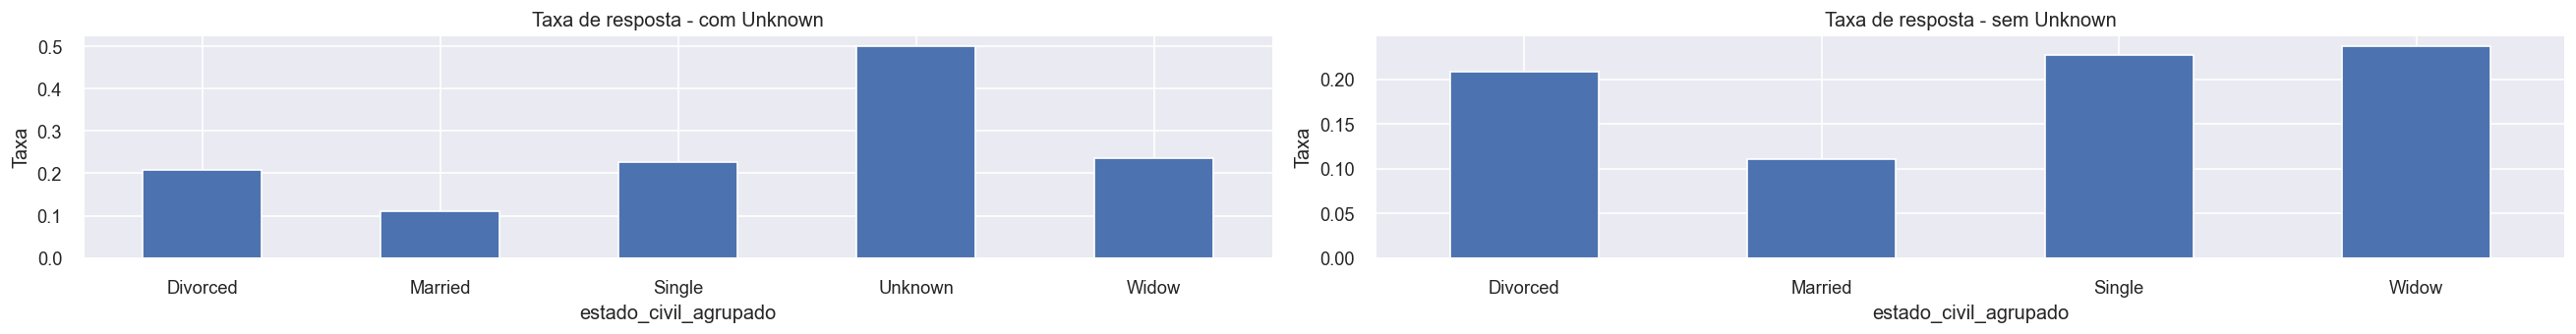

In [300]:
plt.figure(figsize = (22, 3))
df_sem_unknown = df4[df4['estado_civil_agrupado'] != 'Unknown']
plt.subplot(1, 2, 1)
df4.groupby('estado_civil_agrupado')['respondeu_campanha'].mean().plot(kind = 'bar')
plt.title('Taxa de resposta - com Unknown')
plt.ylabel('Taxa')
plt.xticks(rotation = 0)

plt.subplot(1, 2, 2)
df_sem_unknown.groupby('estado_civil_agrupado')['respondeu_campanha'].mean().plot(kind = 'bar')
plt.title('Taxa de resposta - sem Unknown')
plt.ylabel('Taxa')
plt.xticks(rotation = 0)

plt.tight_layout()
plt.show();

* O gráfico 1 expõe a necessidade sobre o tratamento de dados, pois a categoria 'Unknown' possui uma taxa de resposta de aproximandamente 50%, já o gráfico 2 confirma que, entre os dados válidos, o estado civil tem um impacto significativo, em outras palavras, clientes solteiros e viúvos respondem mais às campanhas, e clientes casados respondem substancialmente menos (cerca de metade da taxa de resposta dos viúvos).

### 4.1.7 Distribuição dias_ultima_compra (Recency)

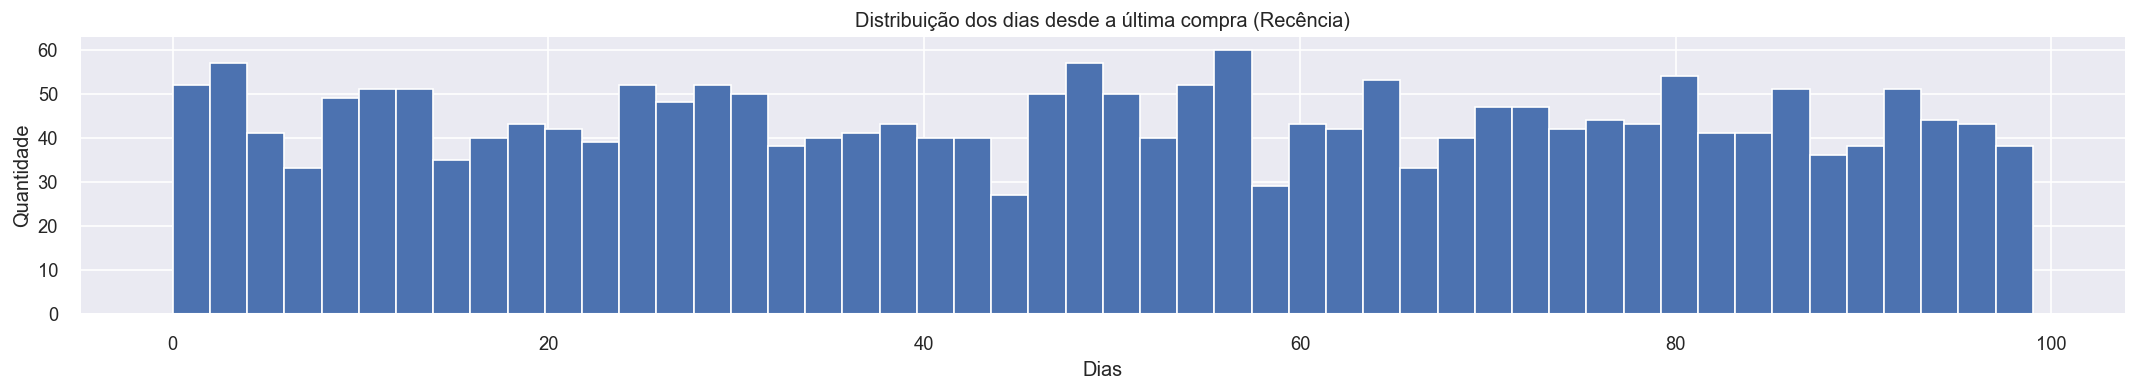

In [301]:
plt.figure(figsize = (22, 3))
df4['dias_ultima_compra'].plot(kind = 'hist', bins = 50)
plt.title('Distribuição dos dias desde a última compra (Recência)')
plt.xlabel('Dias')
plt.ylabel('Quantidade')
plt.show();

* Não há picos ou vales significativos, pois a quantidade de clientes em cada intervalo de dias (de 0 a 100) mantém-se consistentemente na faixa de 30 a 60 clientes. Isso implica que não há um padrão claro de inatividade ou de recompra concentrado em períodos específicos, e a base de clientes está razoavelmente equilibrada em termos de quando fizeram sua última compra.

### 4.2 Validar ou refutar as hipóteses

**1.** Clientes com maior renda gastam mais no total?

**Verdadeira** Clientes com maior renda gastam mais, pois indicam uma correlação positiva forte de 0,67.

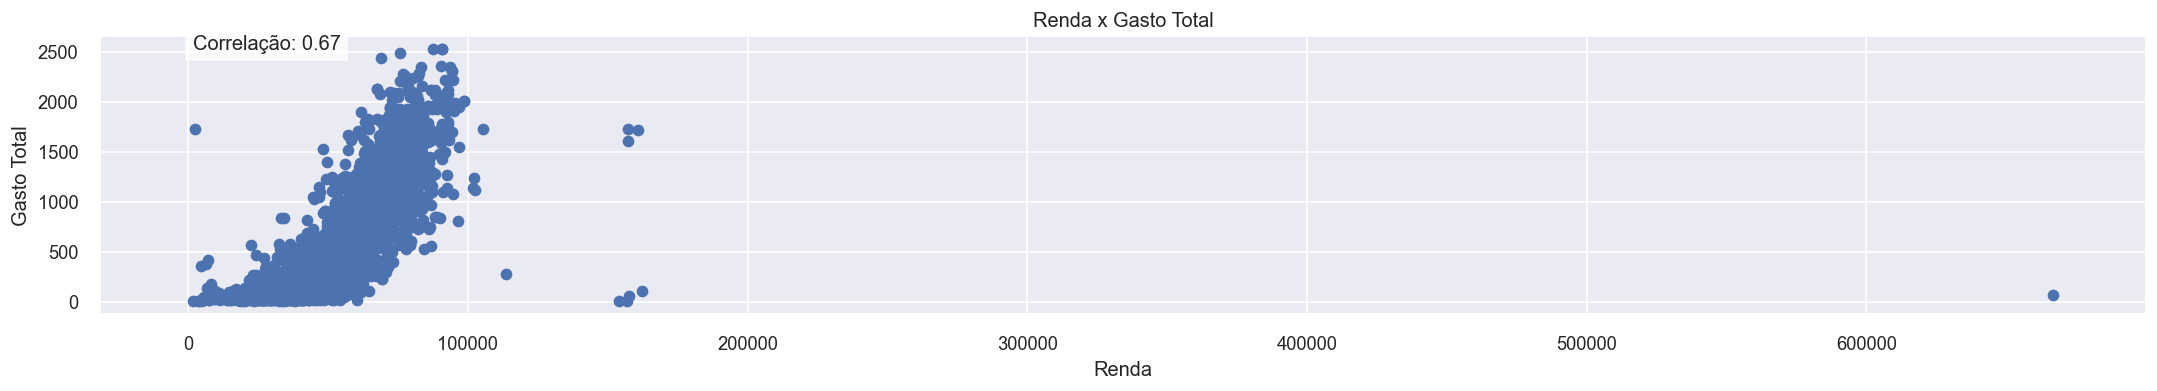

In [302]:
plt.figure(figsize = (22, 3))
correlacao = df4['renda'].corr(df4['monetary'])
plt.scatter(df4['renda'], df4['monetary'])
plt.xlabel('Renda')
plt.ylabel('Gasto Total')
plt.title('Renda x Gasto Total')
plt.text(
    x = df4['renda'].min(),                 
    y = df4['monetary'].max(),             
    s = f'Correlação: {correlacao:.2f}',  
    fontsize = 12,
    bbox = dict(facecolor = 'white', alpha = 0.8)  
)

plt.grid(True)
plt.show();

**2.** Clientes com maior renda gastam proporcionalmente mais em produtos premium e vinhos?

**Verdadeira** Clientes com maior renda não gastam proporcionalmente mais em produtos premium e vinhos, pois não existe uma tendência evidente, ou seja, a correlação é praticamente nula.

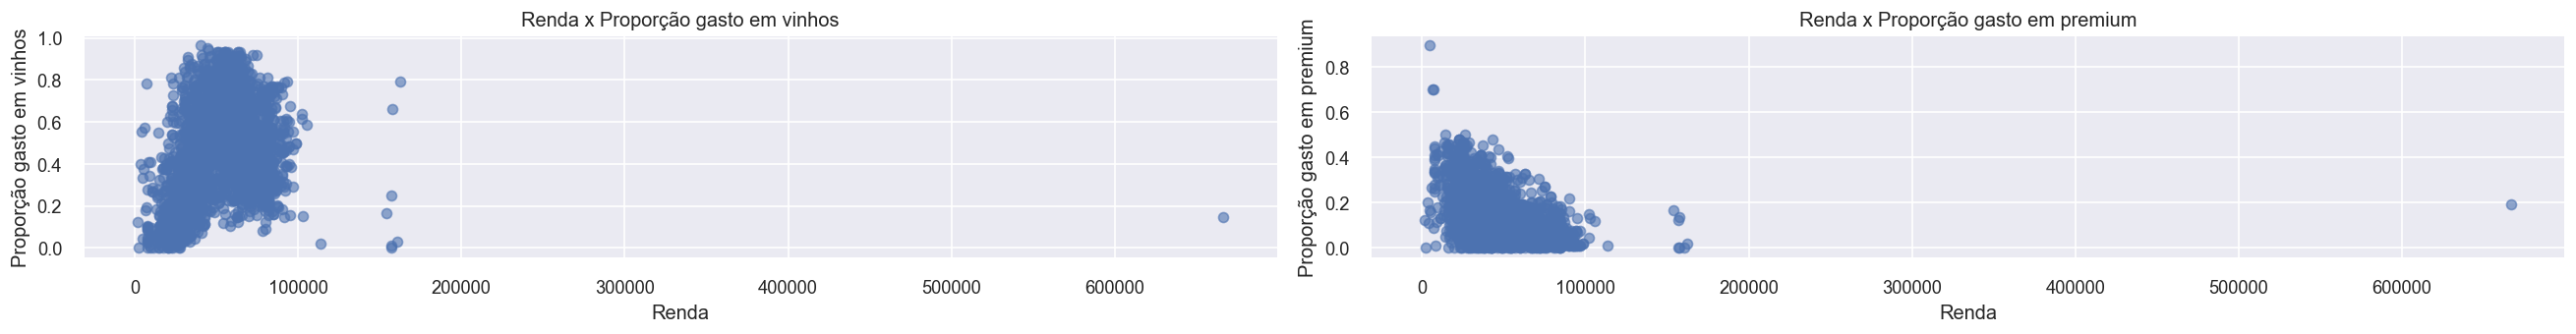

In [303]:
plt.figure(figsize = (22, 3))
plt.subplot(1, 2, 1)
plt.scatter(
    df4['renda'], 
    df4['valor_gasto_vinhos'] / df4['monetary'],
    alpha = 0.6
)
plt.xlabel('Renda')
plt.ylabel('Proporção gasto em vinhos')
plt.title('Renda x Proporção gasto em vinhos')

plt.subplot(1, 2, 2)
plt.scatter(
    df4['renda'], 
    df4['valor_gasto_premium'] / df4['monetary'],
    alpha = 0.6
)
plt.xlabel('Renda')
plt.ylabel('Proporção gasto em premium')
plt.title('Renda x Proporção gasto em premium')
plt.tight_layout()
plt.show();

**3.** Clientes com filhos compram mais frequentemente que clientes sem filhos?

**Falso** Clientes sem filhos compram com mais frequencia ligeiramente maior que clientes com filhos.

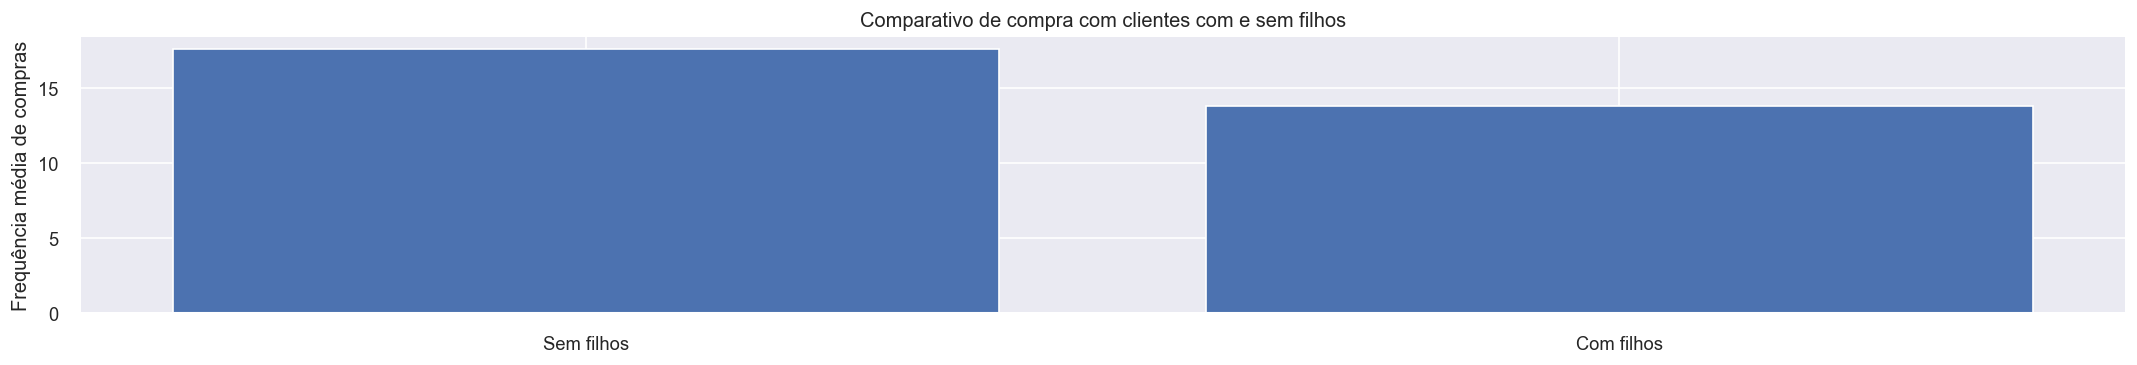

In [304]:
plt.figure(figsize = (22, 3))
tem_filhos = df4['dependentes'].apply(lambda x: 1 if x > 0 else 0) # Criar coluna binária: 1 = tem filhos, 0 = não tem filhos

freq_por_grupo = df4.groupby(tem_filhos)['frequency'].mean()
freq_por_grupo.index = ['Sem filhos', 'Com filhos']

plt.bar(freq_por_grupo.index, freq_por_grupo.values)
plt.ylabel('Frequência média de compras')
plt.title('Comparativo de compra com clientes com e sem filhos')
plt.show();

**4.** Quanto maior o tempo desde a última compra (R), menor o valor gasto?

**Falso** A análise mostra que o tempo desde a última compra não tem impacto significativo no gasto total do cliente. A correlação entre Recency e Monetary é praticamente nula (0.02).

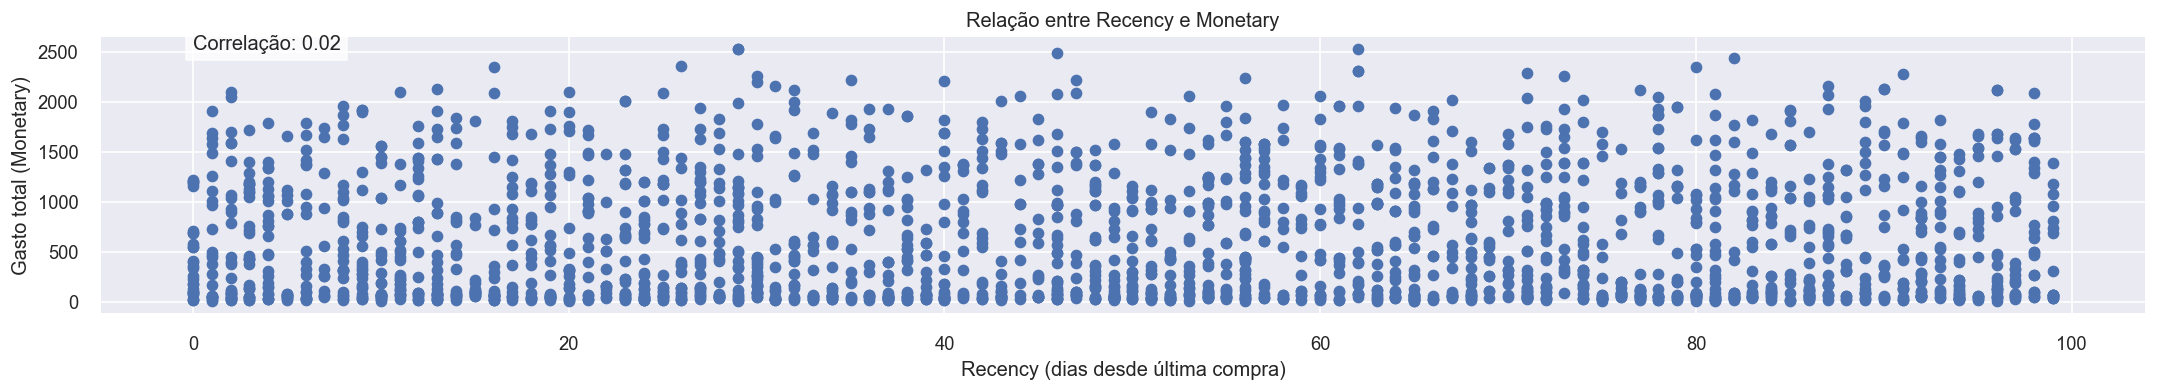

In [305]:
correlacao_rm = df4['recency'].corr(df4['monetary'])

plt.figure(figsize = (22, 3))
plt.scatter(df4['recency'], df4['monetary'])
plt.xlabel('Recency (dias desde última compra)')
plt.ylabel('Gasto total (Monetary)')
plt.title('Relação entre Recency e Monetary')

plt.text(
    x = df4['recency'].min(),
    y = df4['monetary'].max(),
    s = f'Correlação: {correlacao_rm:.2f}',
    fontsize = 12,
    bbox = dict(facecolor = 'white', alpha = 0.8)
)

plt.grid(True)
plt.show();

**5.** Clientes que já aceitaram uma campanha têm maior probabilidade de aceitar outras?

**Verdadeira** Clientes que já aceitaram uma campanha tendem a aceitas outras campanhas sim.

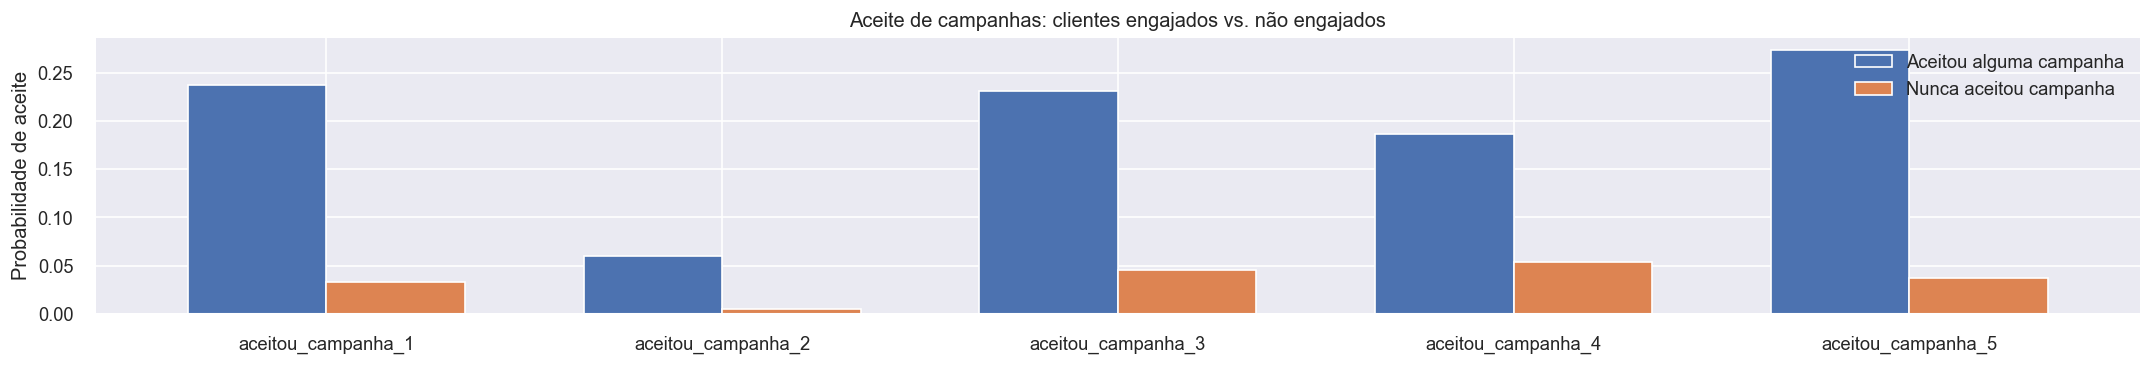

In [306]:
campanhas = [
    'aceitou_campanha_1', 'aceitou_campanha_2', 'aceitou_campanha_3',
    'aceitou_campanha_4', 'aceitou_campanha_5'
]

aceitou_uma = df4[df4['respondeu_campanha'] == 1]
nao_aceitou = df4[df4['respondeu_campanha'] == 0]

prob_aceitou = aceitou_uma[campanhas].mean()
prob_nao_aceitou = nao_aceitou[campanhas].mean()

x = np.arange(len(campanhas))
width = 0.35

plt.figure(figsize = (22, 3))
plt.bar(x - width/2, prob_aceitou, width, label = 'Aceitou alguma campanha')
plt.bar(x + width/2, prob_nao_aceitou, width, label = 'Nunca aceitou campanha')

plt.xticks(x, campanhas)
plt.ylabel('Probabilidade de aceite')
plt.title('Aceite de campanhas: clientes engajados vs. não engajados')
plt.legend()
plt.show();

**6.** Clientes com maior nível educacional possuem maior gasto médio?

**Verdadeira** Clientes com maior nível educacional possuem sim um maior gasto médio.

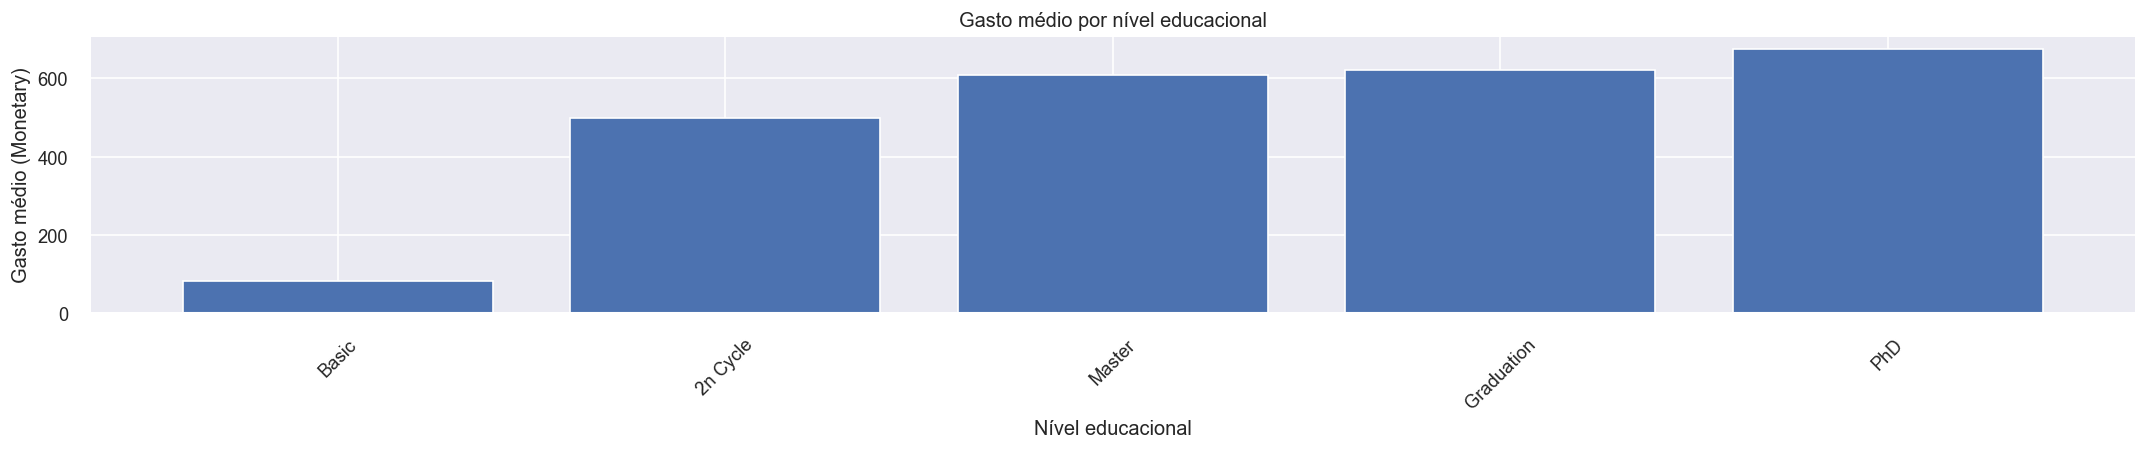

In [307]:
plt.figure(figsize = (22, 3))
gasto_medio = df4.groupby('educacao_agrupado')['monetary'].mean().sort_values()
plt.bar(gasto_medio.index, gasto_medio.values)
plt.ylabel('Gasto médio (Monetary)')
plt.xlabel('Nível educacional')
plt.title('Gasto médio por nível educacional')
plt.xticks(rotation = 45)
plt.show();

**7.** Clientes casados compram mais que clientes solteiros?

**Falso** Clientes casados não compram mais que clientes solteiros, a diferença é é bem sutil, os clientes viúvos é que compram mais.

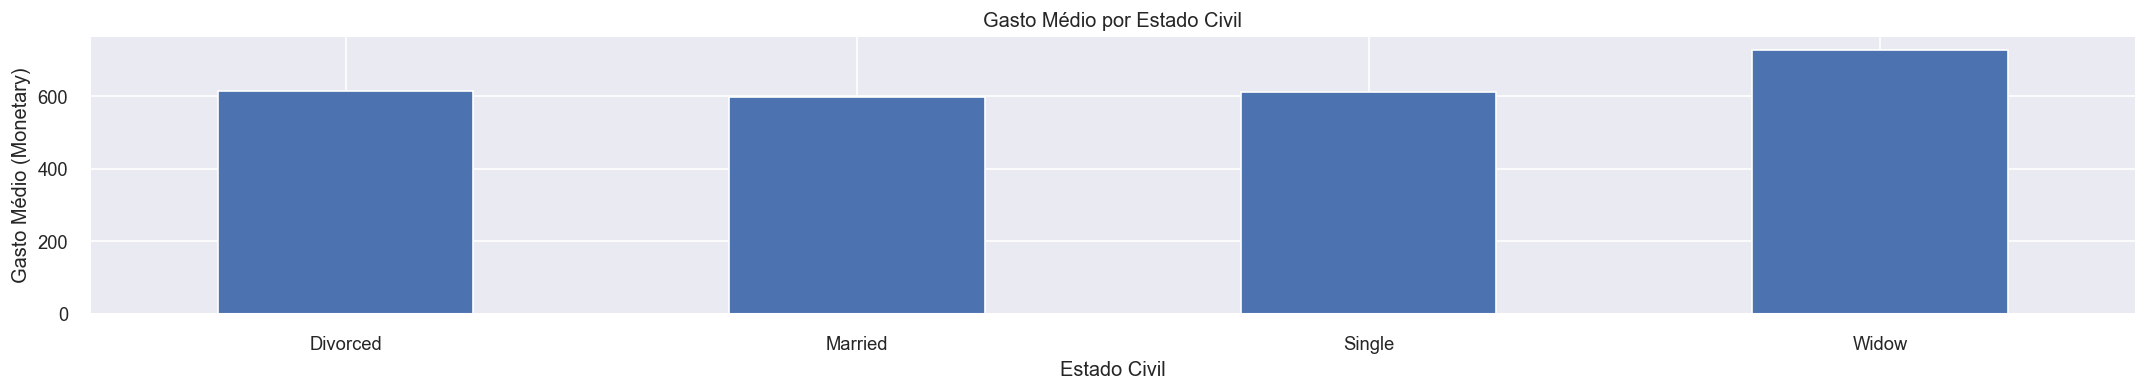

In [308]:
plt.figure(figsize = (22, 3))
gasto_estado_civil = df4.groupby('estado_civil_agrupado')['monetary'].mean()

gasto_estado_civil = gasto_estado_civil.drop('Unknown', errors = 'ignore')

gasto_estado_civil.plot(kind = 'bar')
plt.title('Gasto Médio por Estado Civil')
plt.ylabel('Gasto Médio (Monetary)')
plt.xlabel('Estado Civil')
plt.xticks(rotation = 0)
plt.show();

**8.** Clientes com alta recência (muito tempo sem comprar) têm baixa resposta a campanhas?

**Falso** Clientes que responderam às campanhas apresentaram recency (muito tempo sem comprar) significativamente menor, ou seja, clientes que compraram mais recentemente (baixa recência) são mais propensos a aceitar campanhas, enquanto clientes que estão há muito tempo sem comprar apresentam baixa taxa de resposta.

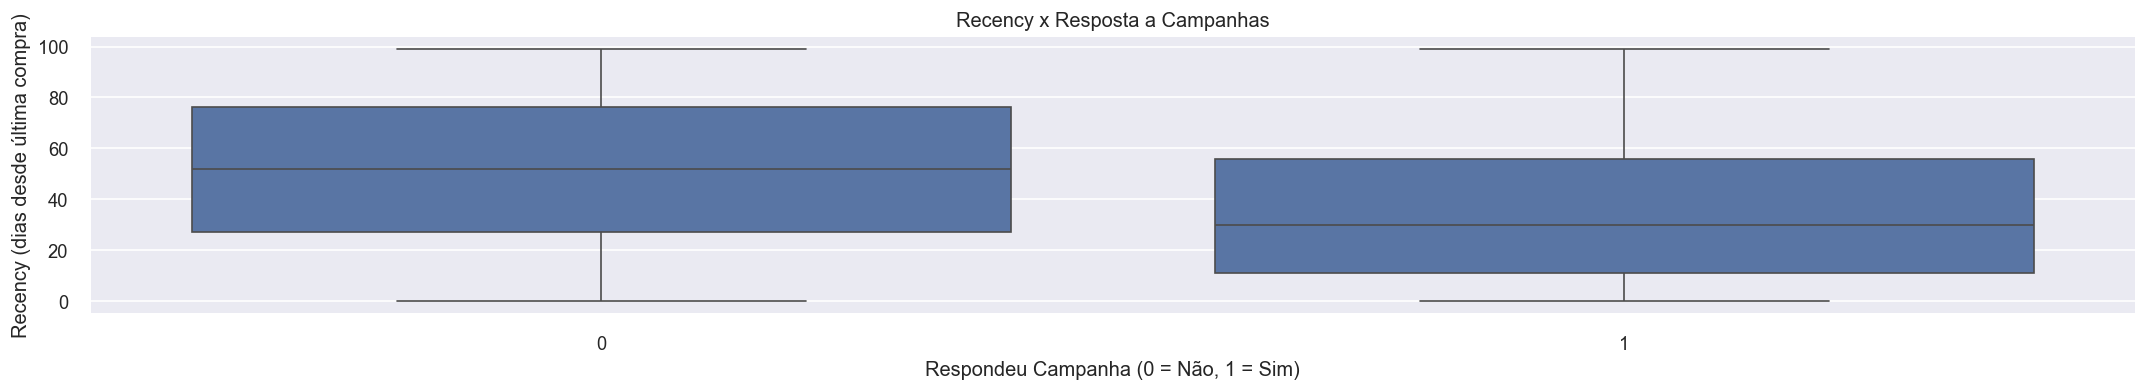

In [309]:
plt.figure(figsize = (22, 3))
sns.boxplot(data = df4, x = 'respondeu_campanha', y = 'recency')
plt.title('Recency x Resposta a Campanhas')
plt.xlabel('Respondeu Campanha (0 = Não, 1 = Sim)')
plt.ylabel('Recency (dias desde última compra)')
plt.show();

**9.** Clientes que compram vinhos tendem a comprar carnes?

**Verdadeira** A correlação existente indica que clientes que gastam mais com vinhos também gastam mais com carnes.

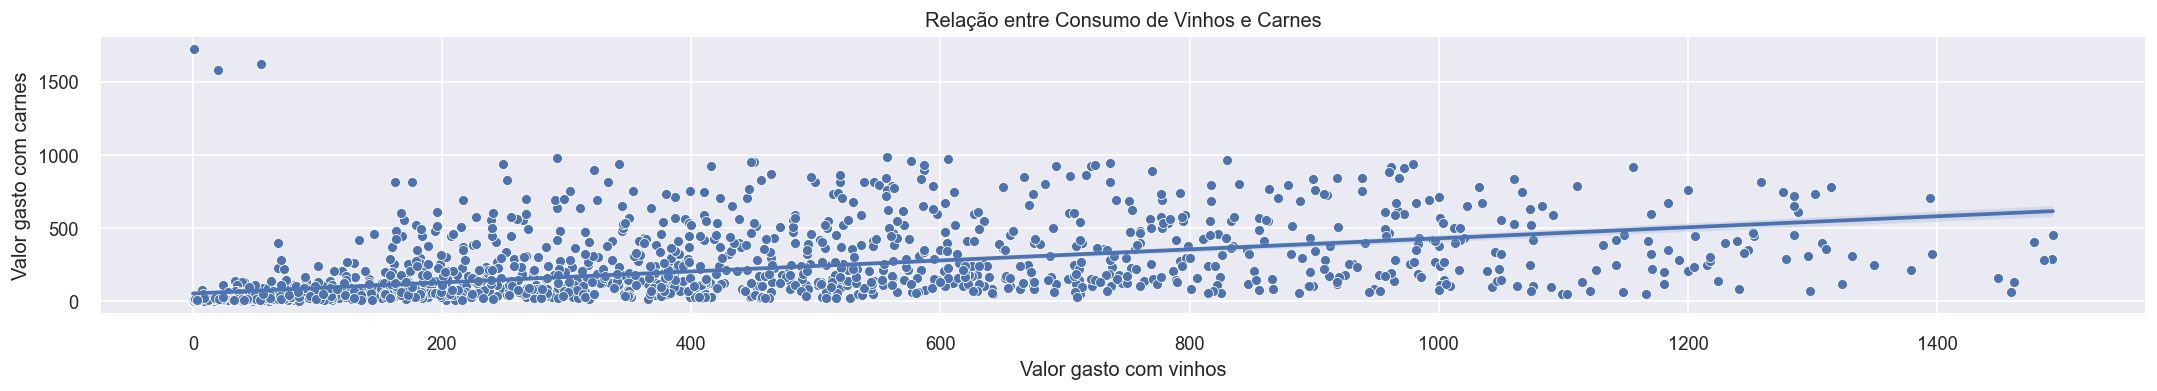

In [310]:
plt.figure(figsize = (22, 3))
sns.scatterplot(
    x = df4['valor_gasto_vinhos'], 
    y = df4['valor_gasto_carnes']
)
sns.regplot(
    x = df4['valor_gasto_vinhos'], 
    y = df4['valor_gasto_carnes'], 
    scatter = False
)

plt.title('Relação entre Consumo de Vinhos e Carnes')
plt.xlabel('Valor gasto com vinhos')
plt.ylabel('Valor gasto com carnes')
plt.grid(True)
plt.show();

**10.** Clientes que compram com desconto gastam menos no total?

**Verdadeira** Clientes que compram com desconto gastam sim menos no total.

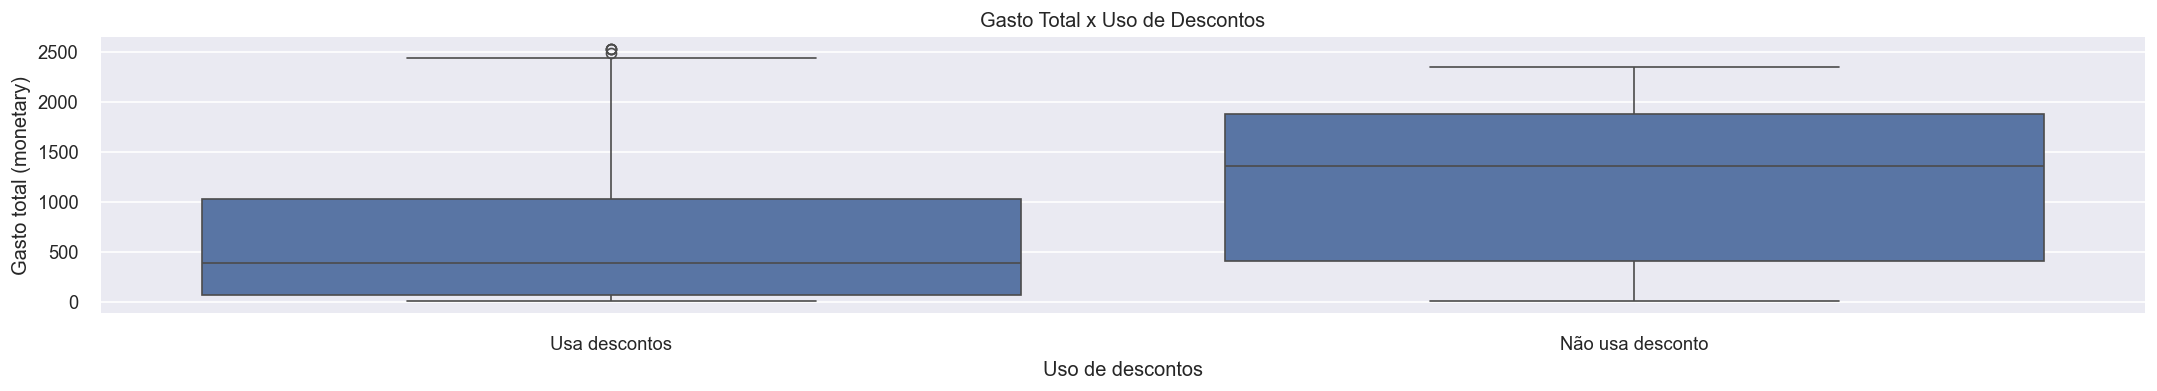

In [311]:
df_tmp = df4.copy()
df_tmp['usa_descontos'] = df_tmp['qtde_compras_descontos'].apply(lambda x: 'Usa descontos' if x > 0 else 'Não usa desconto')

plt.figure(figsize = (22, 3))
sns.boxplot(
    data = df_tmp,
    x = 'usa_descontos',
    y = 'monetary'
)
plt.title('Gasto Total x Uso de Descontos')
plt.xlabel('Uso de descontos')
plt.ylabel('Gasto total (monetary)')
plt.grid(True, axis = 'y')
plt.show();

**11.** Alta renda não significa maior gasto?

**Verdadeira** A análise mostra que alta renda não implica maior gasto total. A correlação entre renda e consumo é baixa, indicando que o comportamento de compra não está diretamente associado ao nível de renda.

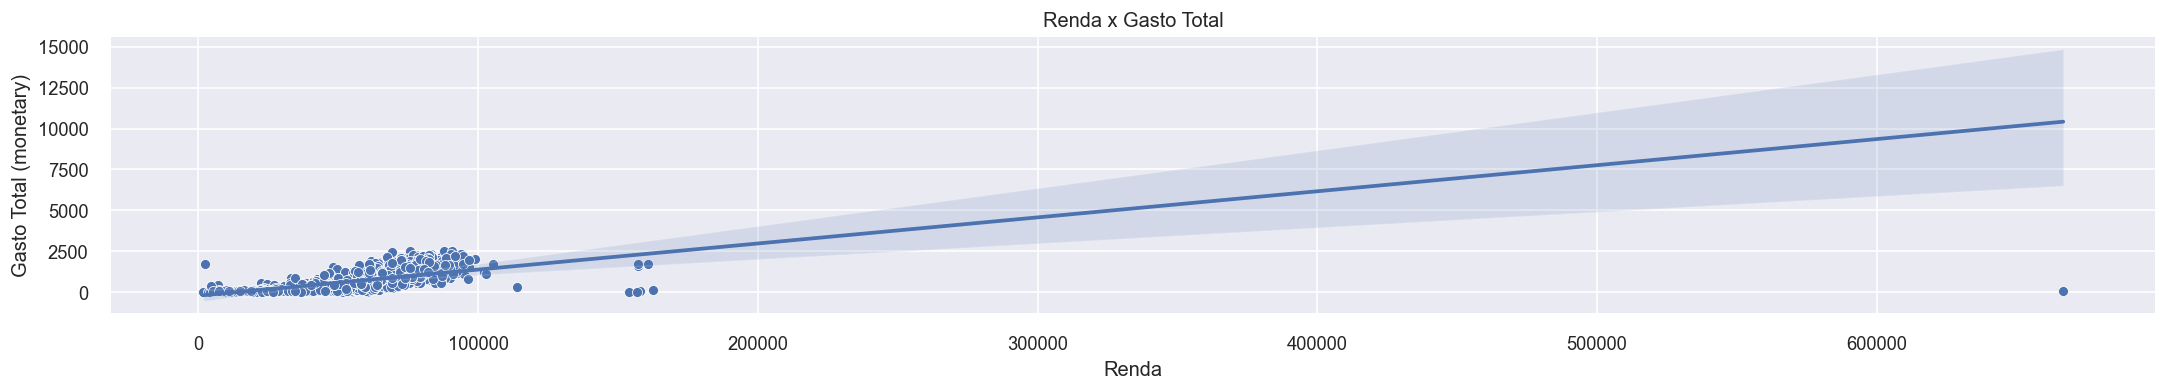

In [312]:
plt.figure(figsize = (22, 3))
sns.scatterplot(x = df4['renda'], y = df4['monetary'])
sns.regplot(x = df4['renda'], y = df4['monetary'], scatter = False)
plt.title('Renda x Gasto Total')
plt.xlabel('Renda')
plt.ylabel('Gasto Total (monetary)')
plt.grid(True)
plt.show();

**12.** Clientes digitais respondem menos a campanhas?

**Falso** Os clientes digitais respondem significativamente mais às campanhas do que os clientes não digitais.

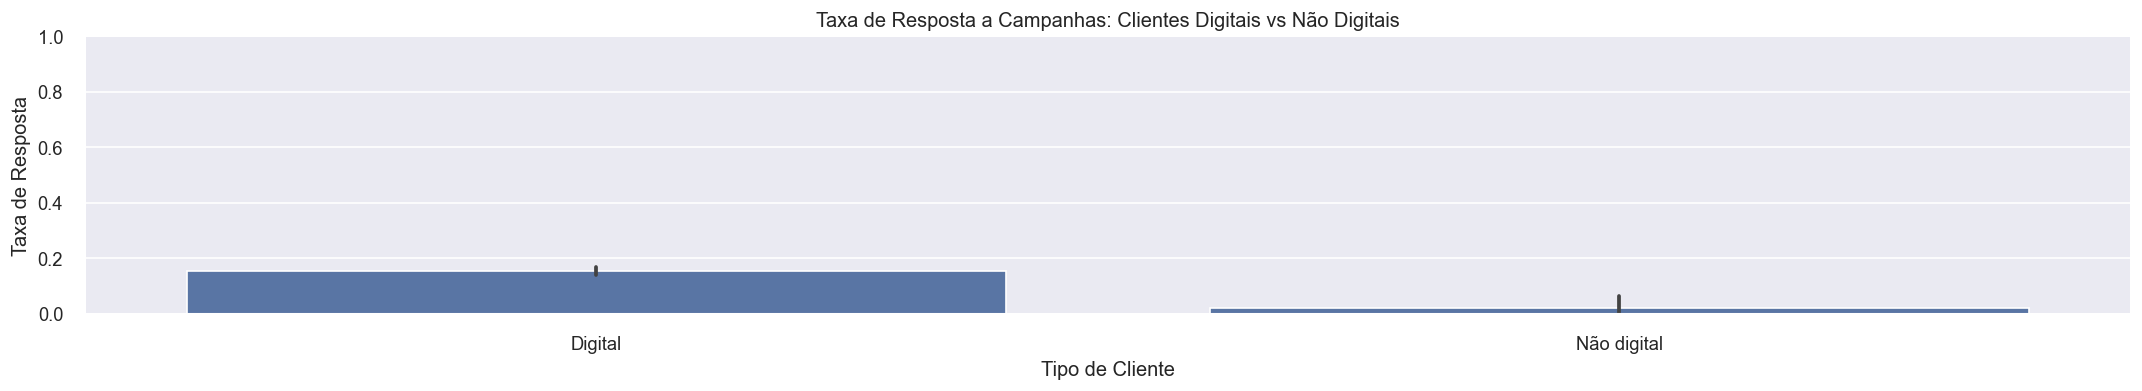

In [313]:
df_tmp = df4.copy()
df_tmp['cliente_digital'] = df_tmp['qtde_compras_website'].apply(
    lambda x: 'Digital' if x > 0 else 'Não digital'
)

plt.figure(figsize = (22, 3))
sns.barplot(
    data = df_tmp,
    x = 'cliente_digital',
    y = 'respondeu_campanha',
    estimator = 'mean'
)

plt.title('Taxa de Resposta a Campanhas: Clientes Digitais vs Não Digitais')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Taxa de Resposta')
plt.ylim(0, 1)
plt.grid(True, axis = 'y')
plt.show();

### 4.3 Selecionar colunas

In [314]:
# Variáveis selecionadas
col_selecionadas = ['renda', 'valor_gasto_vinhos', 'valor_gasto_frutas',
                    'valor_gasto_carnes', 'valor_gasto_peixes', 'valor_gasto_doces',
                    'valor_gasto_premium', 'qtde_compras_descontos', 'qtde_compras_website',
                    'qtde_compras_catalogo', 'qtde_compras_loja_fisica',
                    'qtde_visitas_website', 'aceitou_campanha_1', 'aceitou_campanha_2',
                    'aceitou_campanha_3', 'aceitou_campanha_4', 'aceitou_campanha_5',
                    'respondeu_campanha', 'registrou_reclamaçao', 'educacao_agrupado',
                    'estado_civil_agrupado', 'idade', 'recency', 'frequency', 'monetary', 'dependentes']
df43 = df4[col_selecionadas].copy()

* As colunas abaixo foram removidas pois prejudicam o modelo, por serem identificadores, duplicadas, redundantes ou derivadas de outras features.

    * 'id' - Identificador único. Não contém informação útil para clusterização
    * 'ano_nascimento' - Já tenho a coluna 'idade' e ela é direta, intuitiva e já está na escala correta
    * 'educacao' - Já tenho a coluna 'educacao_agrupado' onde os dados já foram resumidos
    * 'estado_civil' - Já tenho a coluna 'estado_civil_agrupado' onde os dados já foram agrupados
    * 'qtde_criancas' e 'qtde_adolescentes' - Já tenho a coluna 'dependentes', ela é direta e intuitiva
    * 'data_cadastro' - Já tenho a coluna 'recency'
    * 'dias_ultima_compra' - Já tenho a coluna 'recency'
    * 'receita' - Como 'receita' é altamente correlacionada com indicadores de gasto, sua presença introduziria redundância e multicolinearidade

In [315]:
df43.head(3)

,renda,valor_gasto_vinhos,valor_gasto_frutas,valor_gasto_carnes,valor_gasto_peixes,valor_gasto_doces,valor_gasto_premium,qtde_compras_descontos,qtde_compras_website,qtde_compras_catalogo,qtde_compras_loja_fisica,qtde_visitas_website,aceitou_campanha_1,aceitou_campanha_2,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,respondeu_campanha,registrou_reclamaçao,educacao_agrupado,estado_civil_agrupado,idade,recency,frequency,monetary,dependentes
0,58138.0,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,1,0,Graduation,Single,68,58,25,1617,0
1,46344.0,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,Graduation,Single,71,38,6,27,2
2,71613.0,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,Graduation,Married,60,26,21,776,0


# 5. (Modelagem dos dados) Passo 5: Preparação dos dados
##### Neste tópico, os dados poderão ser transformados, ou seja, as variáveis categóricas poderão ser convertidas em números, as variáveis numéricas poderão ser reescalados, em outras palavras, colocadas em uma escala comum. Também neste passo, serão testados os algoritmos de machine learning para avaliação.

### 5.1 Copia dos dados

In [316]:
df5 = df43.copy()

In [317]:
col_numericas = df5.select_dtypes(include = 'number')
col_categoricas = df5.select_dtypes(exclude = 'number')

### 5.1.1 Avaliar qual tipo de transformação aplicar

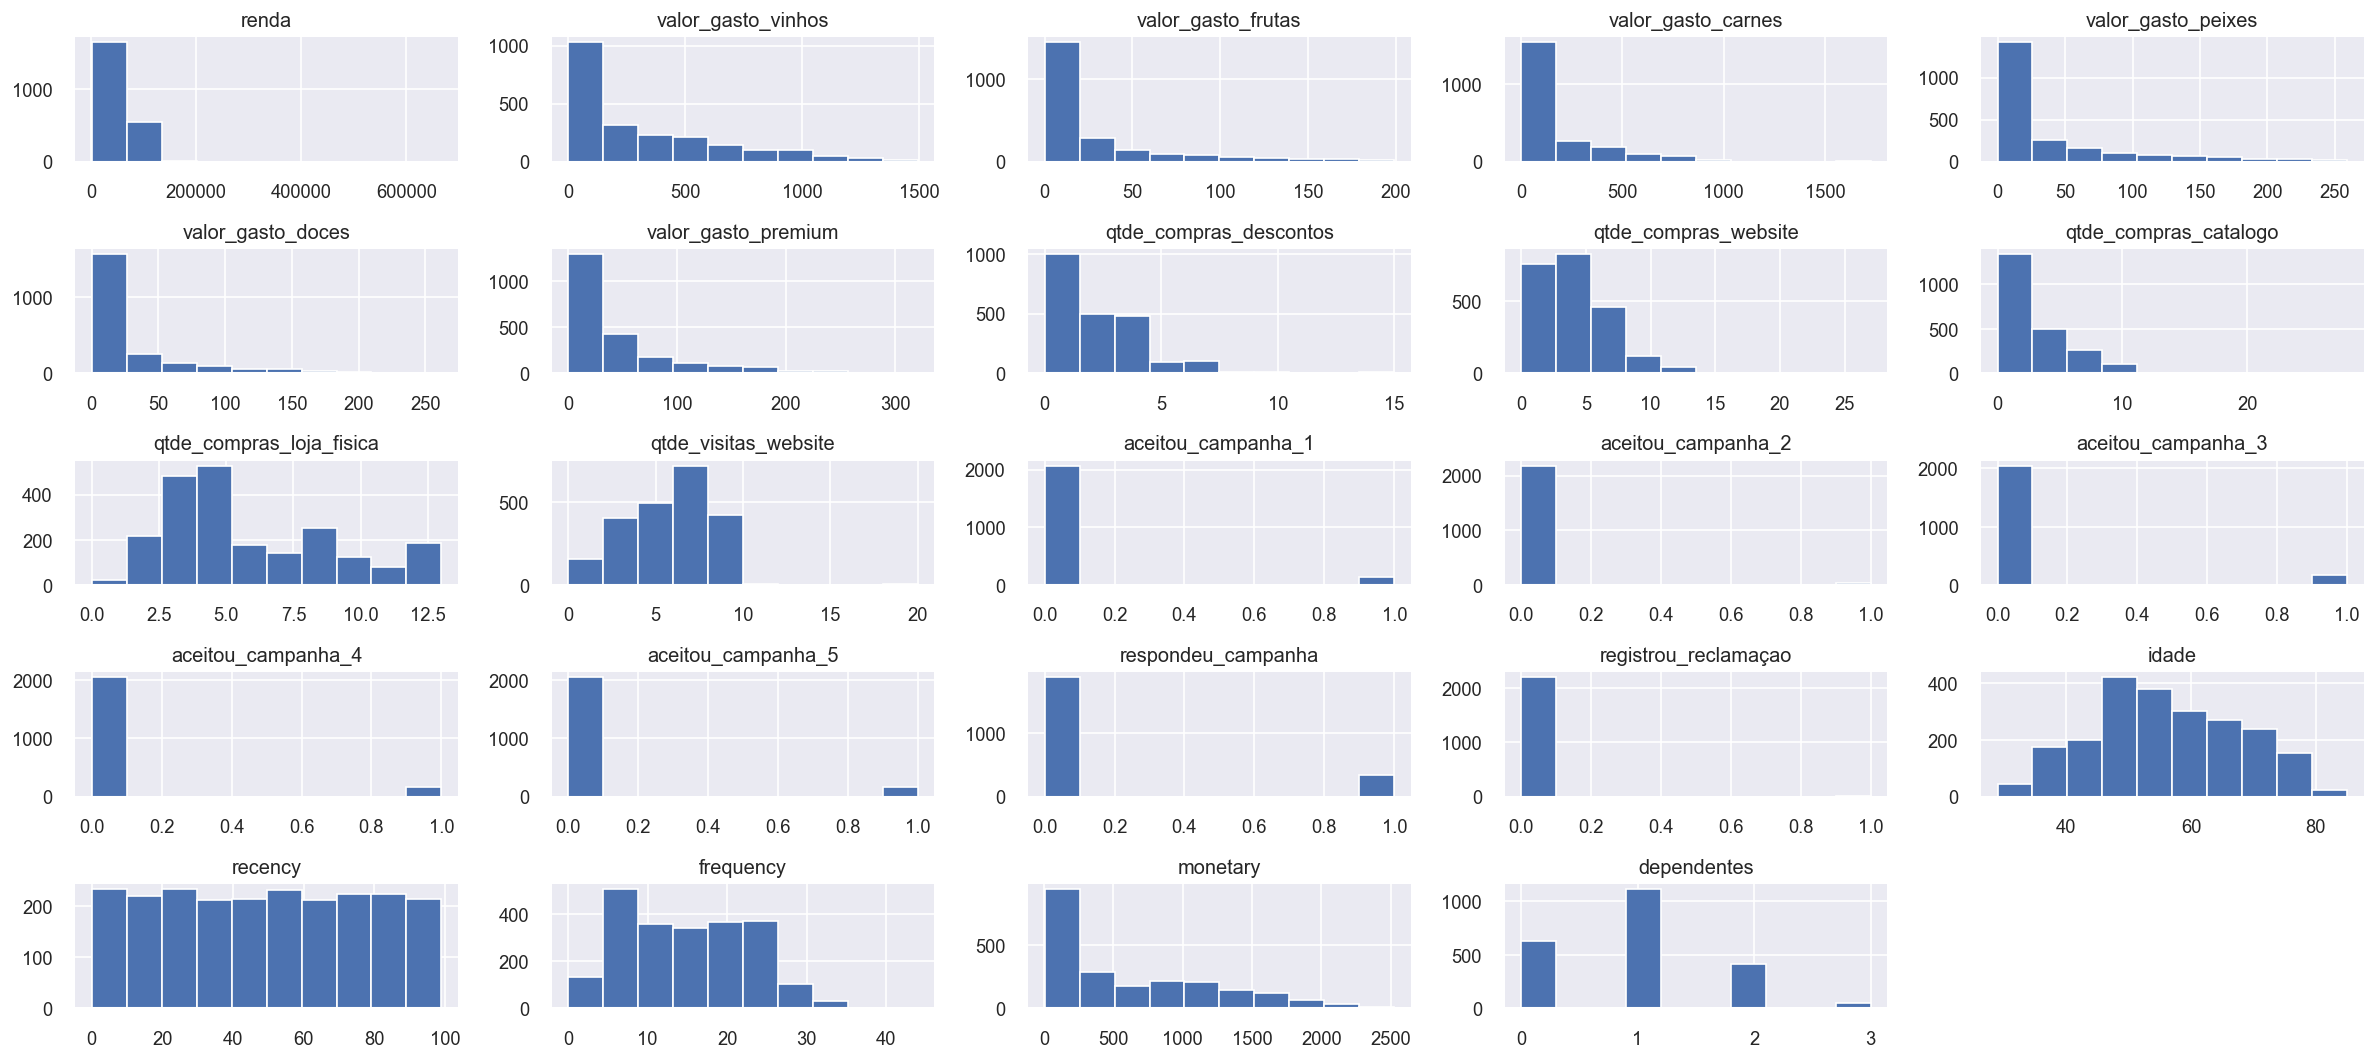

In [318]:
col_numericas.hist()
plt.tight_layout()
plt.show();

* Colunas que devem receber log1p (alta assimetria + valores extremos)
    * renda — valores muito altos e distribuição altamente assimétrica.
    * valor_gasto_vinhos — grande variação e cauda longa puxada por grandes consumidores.
    * valor_gasto_frutas — muitos zeros e poucos valores extremamente altos.
    * valor_gasto_carnes — dispersão muito elevada e presença de outliers.
    * valor_gasto_peixes — assimetria acentuada com min = 0 e máximos distantes da média.
    * valor_gasto_doces — muitos valores pequenos e alguns consumidores fora da curva.
    * valor_gasto_premium — comportamento típico de gasto concentrado e distribuição longa.
    * monetary — soma de gastos altamente assimétrica e influenciada por grandes clientes.

* Colunas que devem ser apenas padronizadas com StandardScaler (escala diferente, mas sem extremos graves)
    * qtde_compras_descontos — contagem pequena que só precisa ser nivelada na escala.
    * qtde_compras_website — escala baixa e sem outliers significativos.
    * qtde_compras_catalogo — contagem moderada que só precisa padronizar.
    * qtde_compras_loja_fisica — variabilidade pequena e sem necessidade de log.
    * qtde_visitas_website — contagem baixa com leve assimetria, normalização resolve.
    * idade — distribuição relativamente uniforme, sem caudas extremas.
    * recency — faixa moderada, mas precisa ser escalada para não dominar outras.
    * frequency — contagem variável porém sem extremos que justifiquem log.
    * dependentes — baixa amplitude, só precisa entrar na mesma escala.

* Colunas binárias não precisam de transformação (0 e 1 já estão padronizados naturalmente)
    * aceitou_campanha_1
    * aceitou_campanha_2
    * aceitou_campanha_3
    * aceitou_campanha_4
    * aceitou_campanha_5
    * respondeu_campanha
    * registrou_reclamaçao

### 5.1.2 Aplicar transformação

In [319]:
# Colunas binárias
cols_bin = ['aceitou_campanha_1',
            'aceitou_campanha_2',
            'aceitou_campanha_3',
            'aceitou_campanha_4',
            'aceitou_campanha_5',
            'respondeu_campanha',
            'registrou_reclamaçao']

# Colunas para log1p
cols_log = ['renda',
            'valor_gasto_vinhos',
            'valor_gasto_frutas',
            'valor_gasto_carnes',
            'valor_gasto_peixes',
            'valor_gasto_doces',
            'valor_gasto_premium',
            'monetary']

# Colunas para padronizar
cols_scale = ['qtde_compras_descontos',
              'qtde_compras_website',
              'qtde_compras_catalogo',
              'qtde_compras_loja_fisica',
              'qtde_visitas_website',
              'idade',
              'recency',
              'frequency',
              'dependentes']

# Colunas categóricas separadas
cols_educ = ['educacao_agrupado']
cols_estado = ['estado_civil_agrupado']

# Ordem correta da educação
educ_levels = [['PhD', 'Master', 'Graduation', '2n Cycle', 'Basic']]

In [320]:
# Pipeline para log1p → scale
log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

# Pipeline para padronização simples
scale_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Estado civil → OneHot
estado_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output = False))
])

# Educação → Ordinal
educ_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories = educ_levels))
])

In [321]:
# ColumnTransformer final
preprocessor = ColumnTransformer(
    transformers = [
        ('log_cols', log_pipeline, cols_log),
        ('scale_cols', scale_pipeline, cols_scale),
        ('educ_ordinal', educ_pipeline, cols_educ),
        ('estado_cat', estado_pipeline, cols_estado),
        ('bin_cols', 'passthrough', cols_bin)
    ],
    remainder = 'drop'
)

In [322]:
df53_array = preprocessor.fit_transform(df5)

### 5.1.3 Obter os nomes das colunas transformadas

In [323]:
# Nome das colunas
log_names = preprocessor.named_transformers_['log_cols'] \
    .named_steps['scaler'].get_feature_names_out(cols_log)

scale_names = preprocessor.named_transformers_['scale_cols'] \
    .named_steps['scaler'].get_feature_names_out(cols_scale)

educ_names = cols_educ

estado_names = preprocessor.named_transformers_['estado_cat'] \
    .named_steps['onehot'].get_feature_names_out(cols_estado)

bin_names = cols_bin

all_columns = (
    list(log_names) +
    list(scale_names) +
    list(educ_names) +
    list(estado_names) +
    list(bin_names)
)

df53 = pd.DataFrame(df53_array, columns = all_columns)

### 5.1.4 Reorganizar as colunas

In [324]:
df53 = df53[['renda',
             'valor_gasto_vinhos',
             'valor_gasto_frutas',
             'valor_gasto_carnes',
             'valor_gasto_peixes', 
             'valor_gasto_doces',
             'valor_gasto_premium', 
             'qtde_compras_descontos', 
             'qtde_compras_website', 
             'qtde_compras_catalogo', 
             'qtde_compras_loja_fisica', 
             'qtde_visitas_website', 
             'aceitou_campanha_1', 
             'aceitou_campanha_2', 
             'aceitou_campanha_3', 
             'aceitou_campanha_4', 
             'aceitou_campanha_5', 
             'respondeu_campanha', 
             'registrou_reclamaçao',
             'educacao_agrupado', 
             'estado_civil_agrupado_Married', 
             'estado_civil_agrupado_Single', 
             'estado_civil_agrupado_Unknown', 
             'estado_civil_agrupado_Widow', 
             'idade',
             'recency',
             'frequency', 
             'monetary', 
             'dependentes']]

# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis

### 6.1 Copia dos dados

In [325]:
df6 = df53.copy()

### 6.2 Identificar as variáveis mais relevantes

### 6.2.1 Correlação entre variáveis

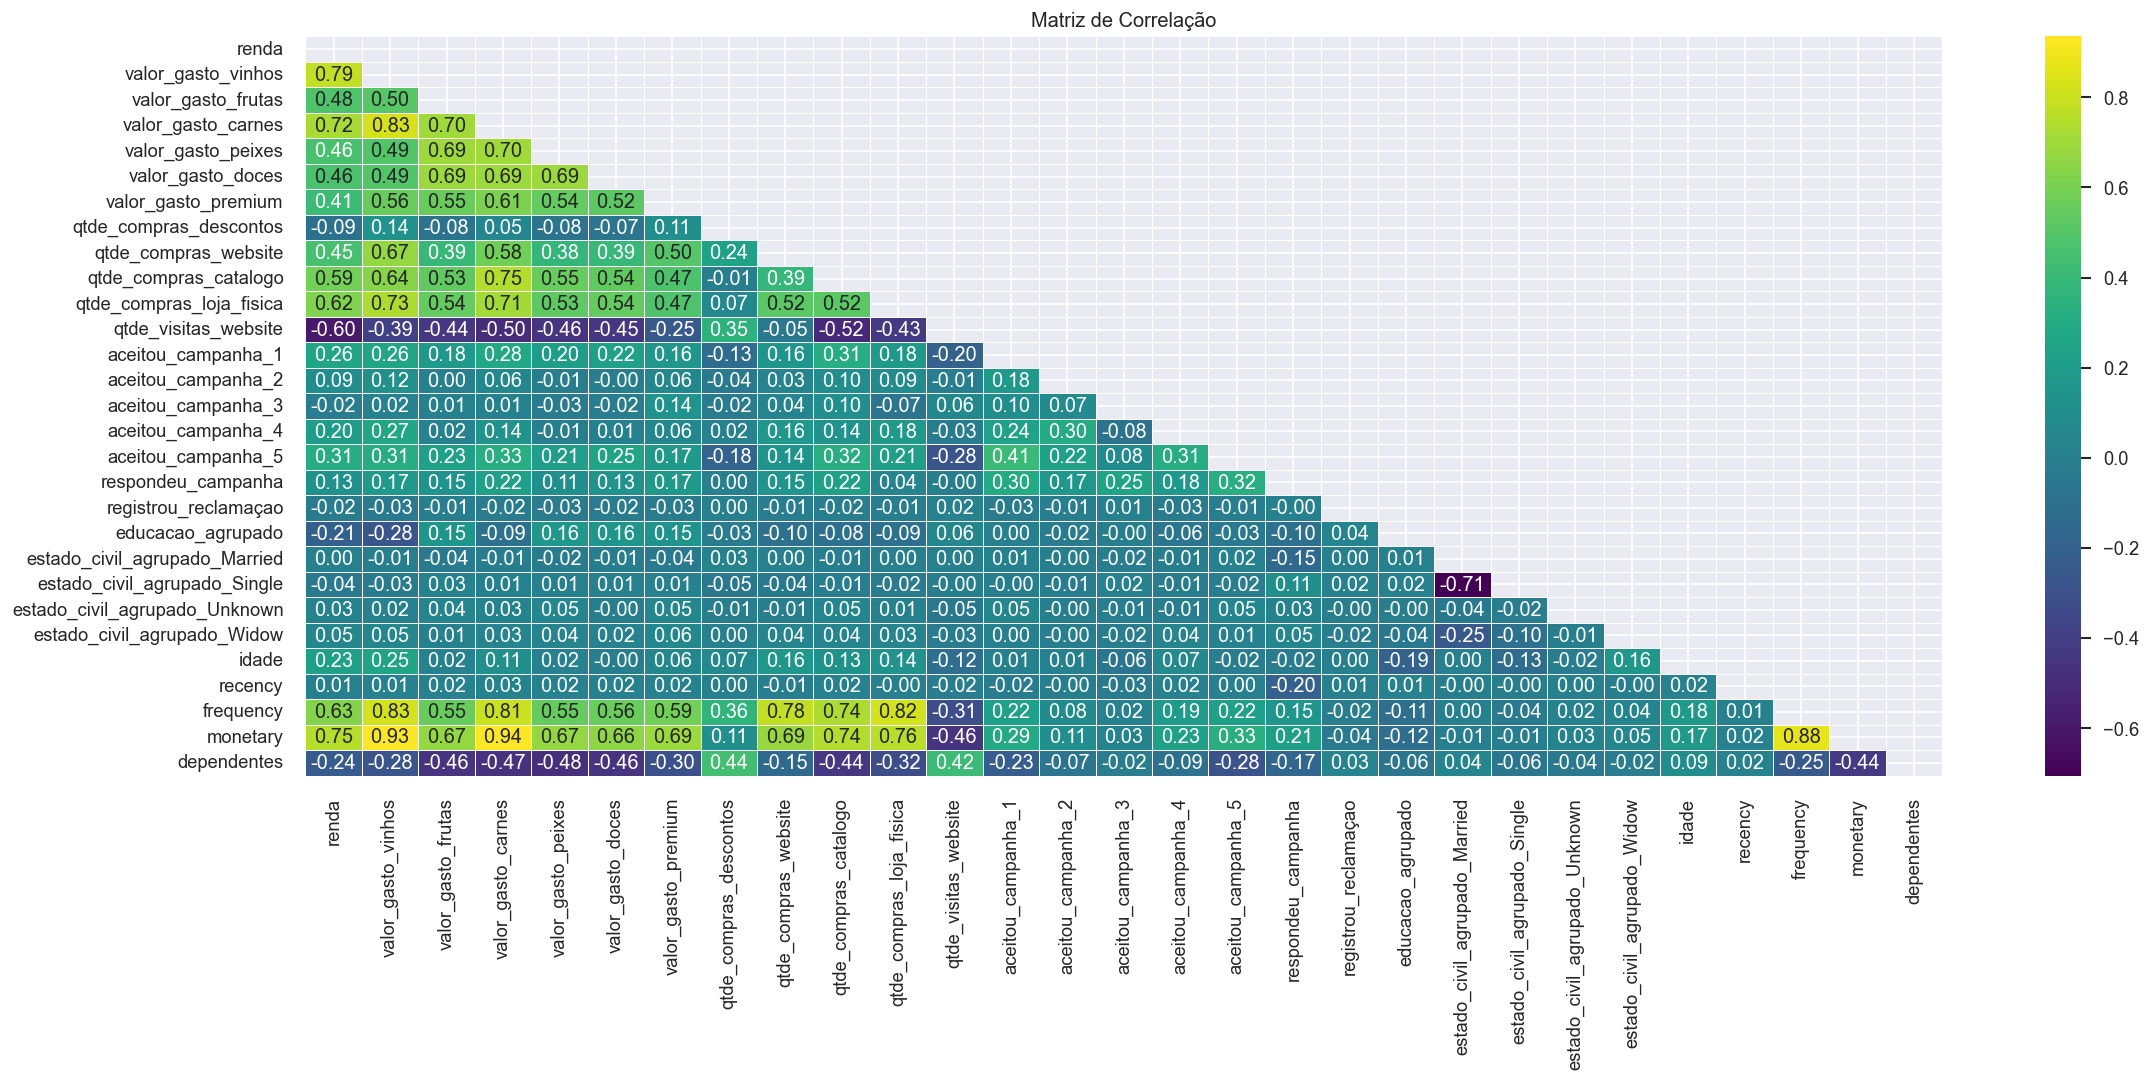

In [326]:
plt.figure(figsize = (22, 8))

corr = df6.corr() # calcula matriz de correlação

mask = np.triu(np.ones_like(corr, dtype = bool)) # criar máscara para esconder o triângulo inferior

sns.heatmap(corr, 
            mask = mask, # oculta metade
            cmap = 'viridis', 
            annot = True, # coloca valores
            fmt = ".2f",
            linewidths = .5)
plt.title('Matriz de Correlação')
plt.show();

* A correlação mede o grau de relacionamento entre duas variáveis, variando entre -1 e 1:
    * 1 → relação linear positiva perfeita
    * 0 → nenhuma relação linear
    * -1 → relação linear negativa perfeita

  Quanto mais próximo desses extremos, mais forte é a relação.

    * 1. Correlação muito alta ( |r| > 0,80 )
        * Significa que as variáveis carregam informações praticamente iguais
        * Forte redundância → uma variável explica quase tudo da outra
        * Alto risco de multicolinearidade

    * 2. Correlação alta (0,60 ≤ |r| ≤ 0,80)
        * Significa que as variáveis têm relação forte, mas não são completamente redundantes

    * 3. Correlação moderada (0,30 ≤ |r| < 0,60)
        * Significa que existe relação, mas cada variável ainda traz muita informação própria

    * 4. Correlação baixa (0,10 ≤ |r| < 0,30)
        * Significa que as variáveis praticamente são independentes uma das outras

    * 5. Correlação muito baixa (|r| < 0,10)
        * Significa uma relação linear praticamente inexistente
        * Variável irrelevante para o comportamento principal ou variável ruidosa

Variáveis com correlação acima de 0,90 foram consideradas redundantes e removidas para evitar duplicidade de informação e reduzir a dimensionalidade.

In [327]:
# transforma a matriz em formato de lista
corr_pairs = (
    corr.unstack() 
        .drop_duplicates() 
        .dropna() 
        .abs()
        .sort_values(ascending = False)
)

# transformar em dataframe
corr_df = corr_pairs.reset_index()
corr_df.columns = ['variavel_1', 'variavel_2', 'correlacao']

# remover correlação da variável com ela mesma
corr_df = corr_df[corr_df['variavel_1'] != corr_df['variavel_2']]

# função para decidir ação
def classificar_correlacao(valor):
    if valor > 0.90:
        return 'REMOVER (redundância muito alta)'
    elif valor > 0.80:
        return 'AVALIAR REMOÇÃO (dependendo da importância)'
    elif valor > 0.50:
        return 'RELACIONADAS (pode manter)'
    else:
        return 'FRACA (manter)'

# aplicar decisão
corr_df['correlacao'] = corr_df['correlacao'].round(2)
corr_df['decisao'] = corr_df['correlacao'].apply(classificar_correlacao)
corr_df.head(10)

,variavel_1,variavel_2,correlacao,decisao
1,valor_gasto_carnes,monetary,0.94,REMOVER (redundância muito alta)
2,valor_gasto_vinhos,monetary,0.93,REMOVER (redundância muito alta)
3,frequency,monetary,0.88,AVALIAR REMOÇÃO (dependendo da importância)
4,valor_gasto_vinhos,valor_gasto_carnes,0.83,AVALIAR REMOÇÃO (dependendo da importância)
5,valor_gasto_vinhos,frequency,0.83,AVALIAR REMOÇÃO (dependendo da importância)
6,qtde_compras_loja_fisica,frequency,0.82,AVALIAR REMOÇÃO (dependendo da importância)
7,valor_gasto_carnes,frequency,0.81,AVALIAR REMOÇÃO (dependendo da importância)
8,renda,valor_gasto_vinhos,0.79,RELACIONADAS (pode manter)
9,qtde_compras_website,frequency,0.78,RELACIONADAS (pode manter)
10,qtde_compras_loja_fisica,monetary,0.76,RELACIONADAS (pode manter)


In [328]:
df63 = df6.drop(columns = ['monetary'], errors = 'ignore')

* A variável 'monetary' foi removida para redundância extrema (0.94 e 0.93) e as outras variáveis relacionadas a ela foram mantidas para evidenciar padrões comportamentais essenciais para identificar os clusters

### 6.3 Reduzir a dimensionalidade

### 6.3.1 PCA (Análise de Componentes Principais)

* O PCA (Principal Component Analysis) é uma técnica estatística usada para reduzir a dimensionalidade de um conjunto de dados, mantendo ao máximo a variabilidade (informação) presente nele. 

  O PCA é um método que transforma várias variáveis originais em um novo conjunto de variáveis chamadas componentes principais, ou seja, o 1º componente principal (PC1) explica a maior parte da variação dos dados, o 2º componente principal (PC2) explica a segunda maior parte, e assim por diante.

  Exemplo: Se você tem 20 variáveis, o PCA pode transformar isso em 3 componentes principais explicando 85% da variação total.

In [329]:
# Instanciando o PCA
pca = PCA() 
pca.fit(df63)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


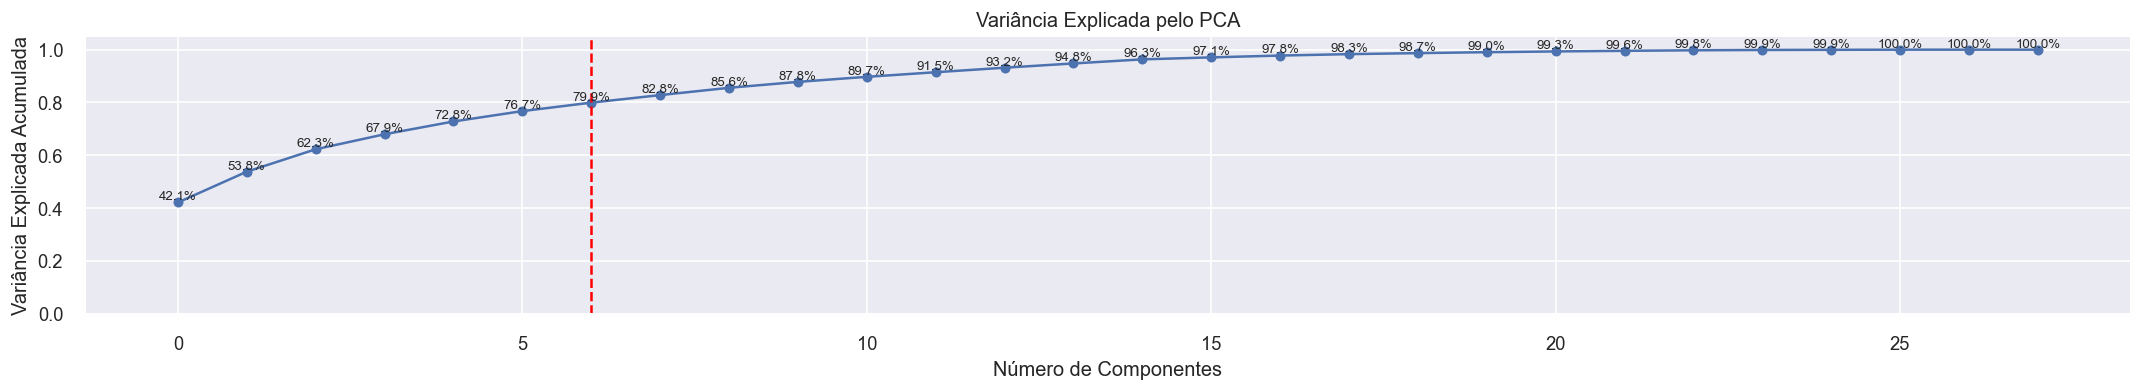

In [330]:
plt.figure(figsize = (22, 3))
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var, marker = 'o')
plt.axvline(x = 6, color = 'red', linestyle = '--') # Linha vertical no componente 6

# Adiciona o texto de percentual sobre cada ponto
for i, v in enumerate(cum_var):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", fontsize = 8, ha = 'center')

plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("Variância Explicada pelo PCA")
plt.grid(True)
plt.ylim(0, 1.05)
plt.show();

* Para escolher quantos componentes usar, procurar o ponto onde a curva estabiliza (cotovelo)
    * 4 componentes = +/- 70% variância explicada
    * 6 componentes = +/- 80% variância explicada 
    * 10 componentes = +/- 90% variância explicada 

    Será usado 6 componentes, ou seja, 80% de variância explicada 

In [331]:
qtde_components = 3
pca = PCA(n_components = qtde_components)
pca_data = pca.fit_transform(df63)

In [332]:
df_pca = pd.DataFrame(
    pca_data,
    columns = [f"PCA_{i+1}" for i in range(qtde_components)]
)

df_pca.head()

,PCA_1,PCA_2,PCA_3
0,3.874267,0.015149,1.153767
1,-3.198247,0.104316,-0.951028
2,2.812680,-0.607202,0.168651
3,-2.545921,-1.087614,0.640328
4,1.254649,0.748839,0.255338


* Interpretação dos componentes do PCA:
    * Foi reduzido o dataset final para 6 colunas, mas cada coluna do PCA é formada por TODAS as 29 variáveis originais.

* Os números que aparece são os loadings (pesos), por exemplo 29 variáveis originais ➝ X1, X2, X3, ..., X29
    
* E escolher 6 componentes, seria como:

    * PCA_1 (componente 1) = 0.33×monetary + 0.32×carne + 0.30×frequency + ... + outros 26 termos

    * PCA_2 (componente 2) = 0.51×qtde_descontos + 0.41×dependentes + ... + outros 28 termos

### 6.3.2 UMAP (Uniform Manifold Approximation and Projection)

* Quando instalar a bibliotéca do umap, utilizar umap-learn, conforme mostrado abaixo:
* pip install umap-learn
* UMAP é menos preciso e indicado para muitos dados devido sua maior simplicidade matemática, contudo ele é ótimo para ter uma ideia de quantos clusters existem (estrutura global)

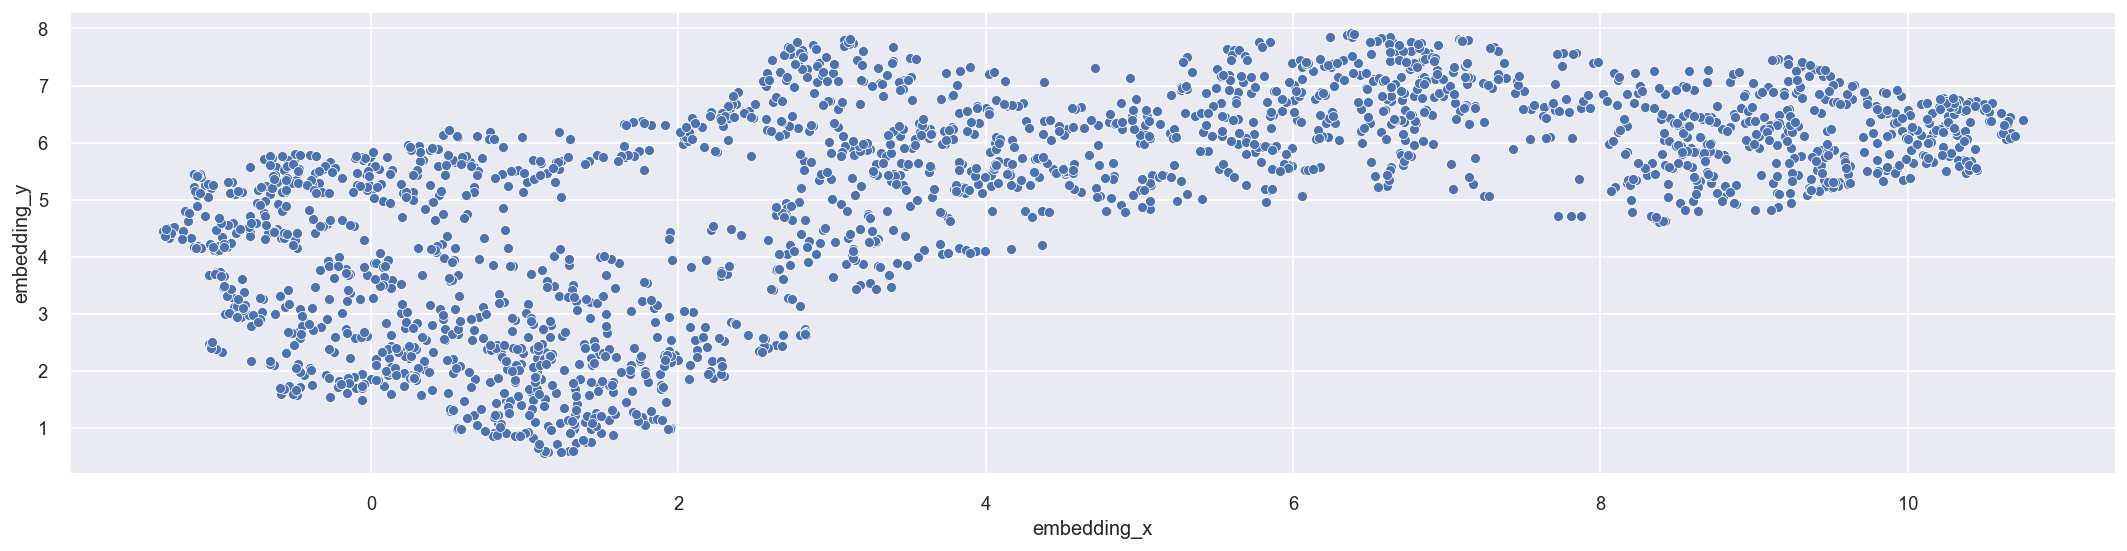

In [333]:
plt.figure(figsize = (22, 5))
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df63)

#Embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# Plotando o UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_umap);

* O que analisar neste gráfico?

    * Se os pontos com as mesmas cores estiverem próximos uns dos outros, significa que na alta dimensionalidade a probabilidade dos os pontos estarem no mesmo cluster é alta

### 6.3.3 t-SNE (t-Distributed Stochastic Neighbor Embedding)

* t-SNE é mais preciso e indicado para poucos dados devido sua complexidade matemática, porém ele é ótimo para confirmar a densidade e a separação local desses grupos (estrutura local).

* Um cluster é considerado **denso** quando os pontos de dados que o compõem estão muito próximos uns dos outros em comparação com a distância desses pontos para quaisquer outros pontos fora do grupo, em termos práticos, significa que as observações dentro desse grupo são muito semelhantes em relação a todas as variáveis.

  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init_

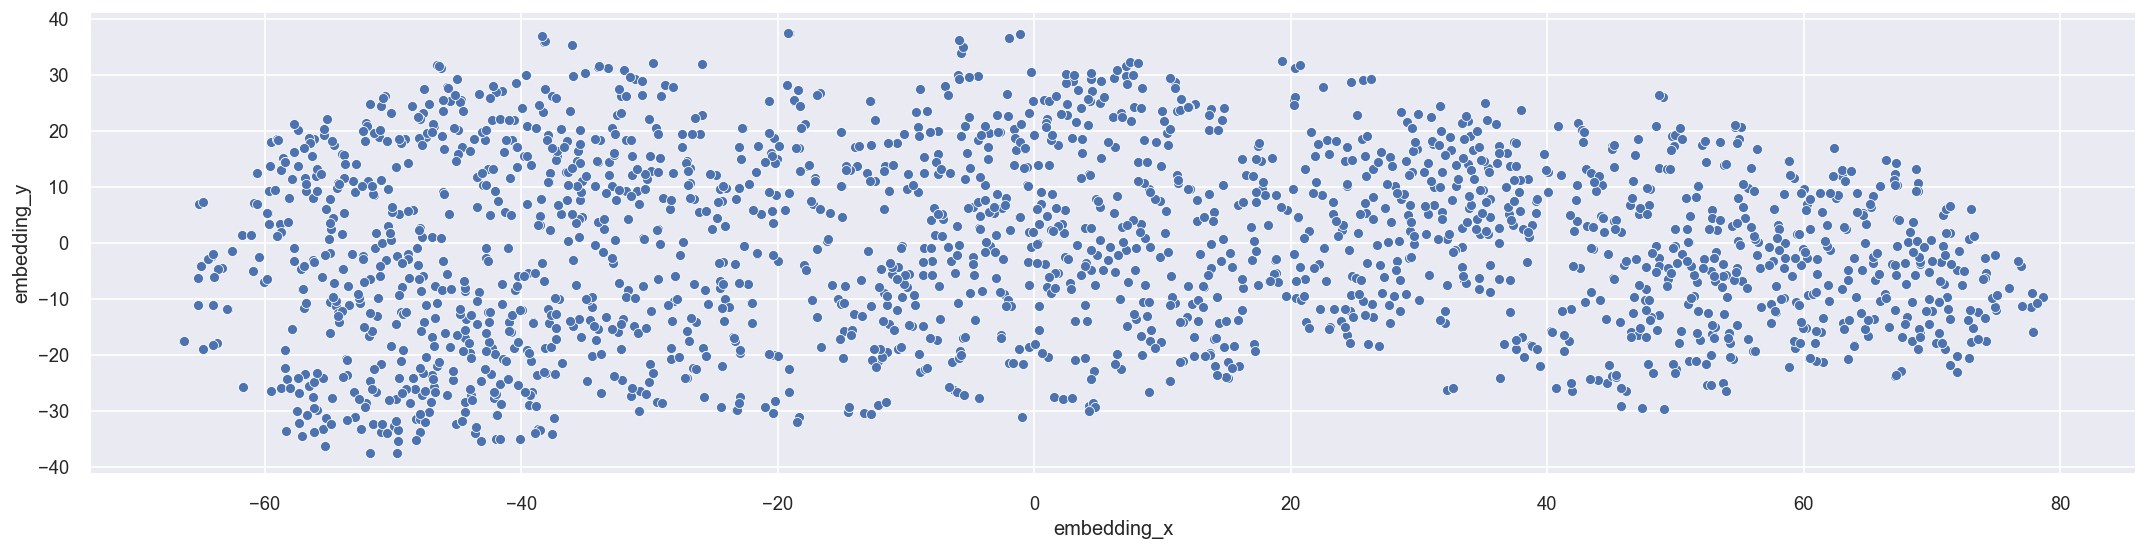

In [334]:
plt.figure(figsize = (22, 5))
reducer = TSNE(n_components = 2, random_state = 42) # n_components = 2 significa reduzir para 2d
embedding = reducer.fit_transform(df63)

#Embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plotando o t_SNE
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca);

* As técnicas de redução de dimensionalidade (UMAP e t-SNE) não evidenciaram uma clara separação em clusters, indicando que os dados apresentam um alto grau de similaridade com os demais, dificultando a distinção de grupos bem delimitados.

### 6.3.4 Árvores

* Para utlizar as árvores, é preciso encontrar uma variável resposta ou uma variável de interesse para este problema, ou seja, transformar um problema não supervisionado para um supervisionado e pensando no negócio, preciso encontrar uma variável onde eu teria uma maior separação entre os clusters, neste caso utilizaremos a variável 'monetary', pois refere-se a quanto o cliente gastou, e o problema precisa definir um grupo de pessoas mais relevantes para empresa e como relevância busca-se as pessoas que gastam mais, a variável referente a faturamento seria a mais indicada para o problema em questão

Obs.: Como esta sendo utilizado uma árvore, os dados não precisam estar transformados

In [335]:
# Separando as variáveis em resposta e preditoras
x = df6.drop(columns = 'monetary', axis = 1)
y = df6['monetary']

# Definição do modelo
rf_modelo = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Treinando o modelo
rf_modelo.fit(x, y)

# Folhas
df_folhas = pd.DataFrame(rf_modelo.apply(x))

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


* Conceito por trás da técnica de usar árvores para identificar padrões de clusters:
    * Cada árvore de decisão divide os dados em "folhas" (nós terminais), onde cada folha representa uma combinação única de regras de decisão. Amostras que caem na mesma folha são similarmente classificadas pela árvore

    * E por que isso funciona para clusterização?, as amostras similares tendem a cair nas mesmas folhas, a matriz de folhas cria uma assinatura única para cada amostra, essa assinatura captura padrões complexos não lineares, ou seja, cada folha final é um <span style = "color:yellow">cluster natural</span>

In [336]:
df_folhas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2346,2187,2238,2311,2325,2376,2109,2288,2331,2277,2280,2105,2289,2270,2051,2253,2223,2095,2225,2038,2372,2102,2253,2274,2307,2340,2280,2330,2227,2033,2090,2235,2249,2217,2073,2284,2372,2311,2065,2235,2085,2179,2272,2270,2274,2330,2308,2268,2345,2229,2235,2147,2320,2363,2386,2233,2170,2267,2239,2367,2228,2164,2274,2323,2205,2270,2355,2182,2352,2281,2264,2091,2219,2165,2096,2300,2342,2295,2269,2075,2232,2296,2381,1997,2105,2270,2274,2316,2282,2331,2026,2073,2238,2192,2139,2342,2296,2297,2170,2247
1,164,184,206,210,142,207,171,310,191,221,161,191,191,194,186,234,215,283,224,191,157,197,193,228,199,201,292,202,176,318,180,193,200,207,176,191,239,182,183,238,162,185,155,224,217,187,173,195,215,170,165,230,216,199,222,213,148,165,189,197,180,302,192,196,175,184,179,170,176,199,196,187,183,179,200,182,182,153,203,280,201,180,165,196,179,189,160,182,218,212,196,203,183,179,189,217,203,163,183,169
2,1407,1456,1450,1643,1653,1463,1478,1727,1449,1518,1488,1433,1392,1419,1454,1416,1447,1453,1662,1458,1420,1516,1412,1506,1496,1509,1439,1462,1452,1464,1377,1818,1486,1419,1495,1749,1508,1488,1443,1380,1470,1428,1696,1497,1442,1335,1457,1408,1472,1383,1463,1516,1559,1533,1538,1825,1593,1447,1444,1492,1435,1666,1676,1453,1405,1581,1423,1500,1644,1548,1505,1472,1840,1420,1486,1460,1489,1471,1450,1453,1453,1436,1472,1476,1481,1466,1495,1490,1421,1475,1496,1428,1401,1696,1660,1423,1487,1488,1800,1442
3,484,470,506,599,450,442,618,456,556,529,527,448,439,453,463,464,584,347,396,442,443,390,522,544,373,563,378,585,591,363,395,484,525,516,409,543,488,461,452,590,467,452,510,437,488,407,453,448,452,452,554,626,433,353,402,464,612,588,543,537,619,487,514,480,521,426,409,514,581,453,495,584,321,634,412,570,620,521,513,370,440,437,576,507,579,596,510,450,594,425,479,467,536,521,465,462,570,442,351,490
4,1209,1496,1141,1499,1458,1240,1136,1564,1298,1341,1233,1278,1234,1365,1135,1250,1296,1250,1266,1253,1123,1286,1208,1306,1245,1304,1092,1179,1263,1176,1187,1181,1261,1260,1303,1508,1199,1272,1149,1484,1237,1074,1536,1222,1164,1345,1243,1502,1270,1464,1215,1317,1262,1238,1303,1514,1478,1241,1244,1187,1235,1191,1522,1130,1245,1452,1192,1264,1503,1490,1309,1077,1503,1253,1298,1291,1266,1266,1231,1281,1244,1222,1364,1284,1283,1158,1320,1287,1375,1302,1229,1276,1172,1578,1189,1295,1244,1300,1242,1187


### 6.4 UMAP (após RandomForestRegressor)

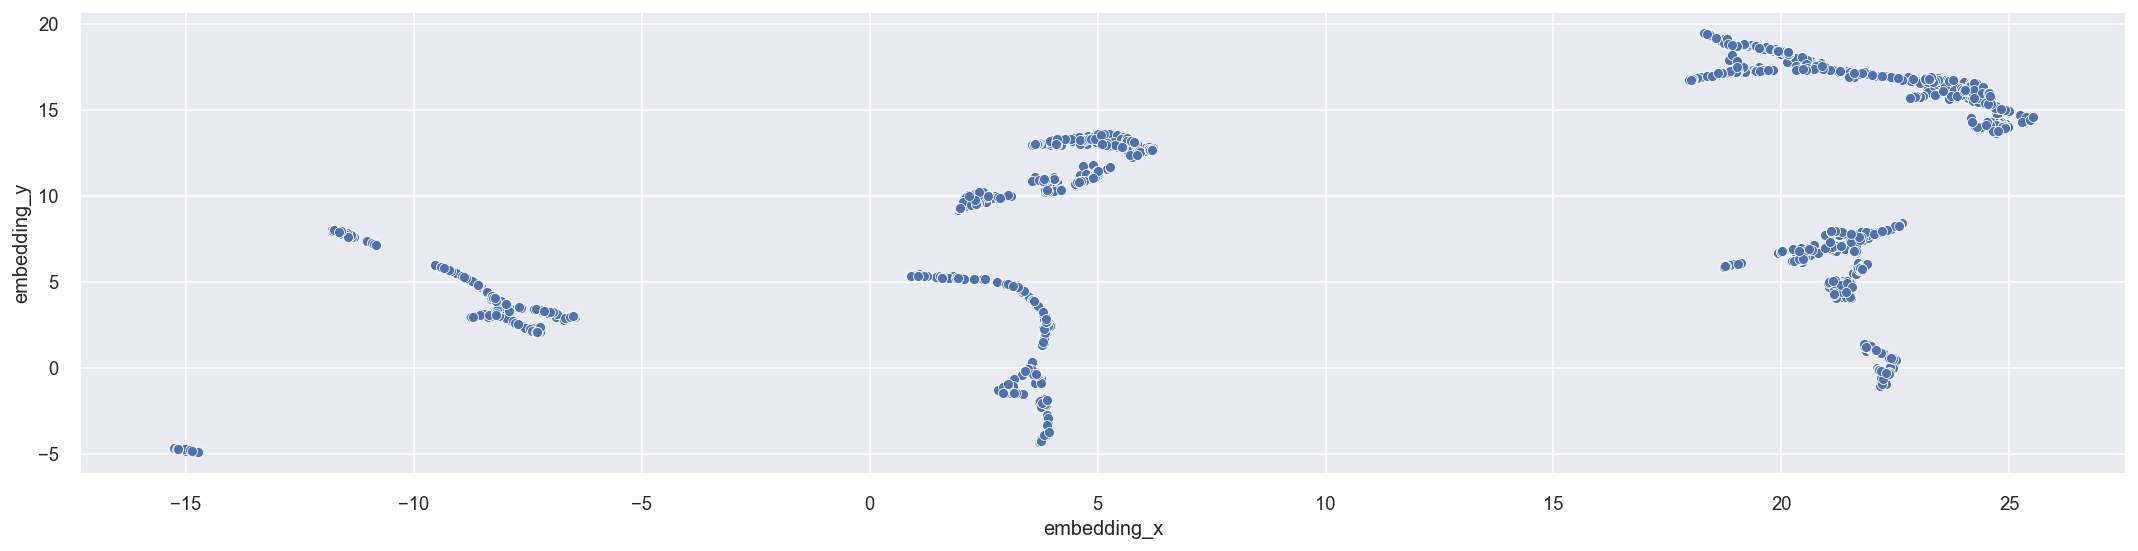

In [337]:
plt.figure(figsize = (22, 5))
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_folhas)

#Embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# Plotando o UMAP
sns.scatterplot(x = 'embedding_x',
                y = 'embedding_y',
                data = df_umap);

* No gráfico do UMAP (após RandomForestRegressor) é possivel identificar visualmente cerca de 5 a 6 grupos principais de pontos bem definidos. O UMAP é bom para estimar o número provável de clusters.

### 6.5 t-SNE (após RandomForestRegressor)

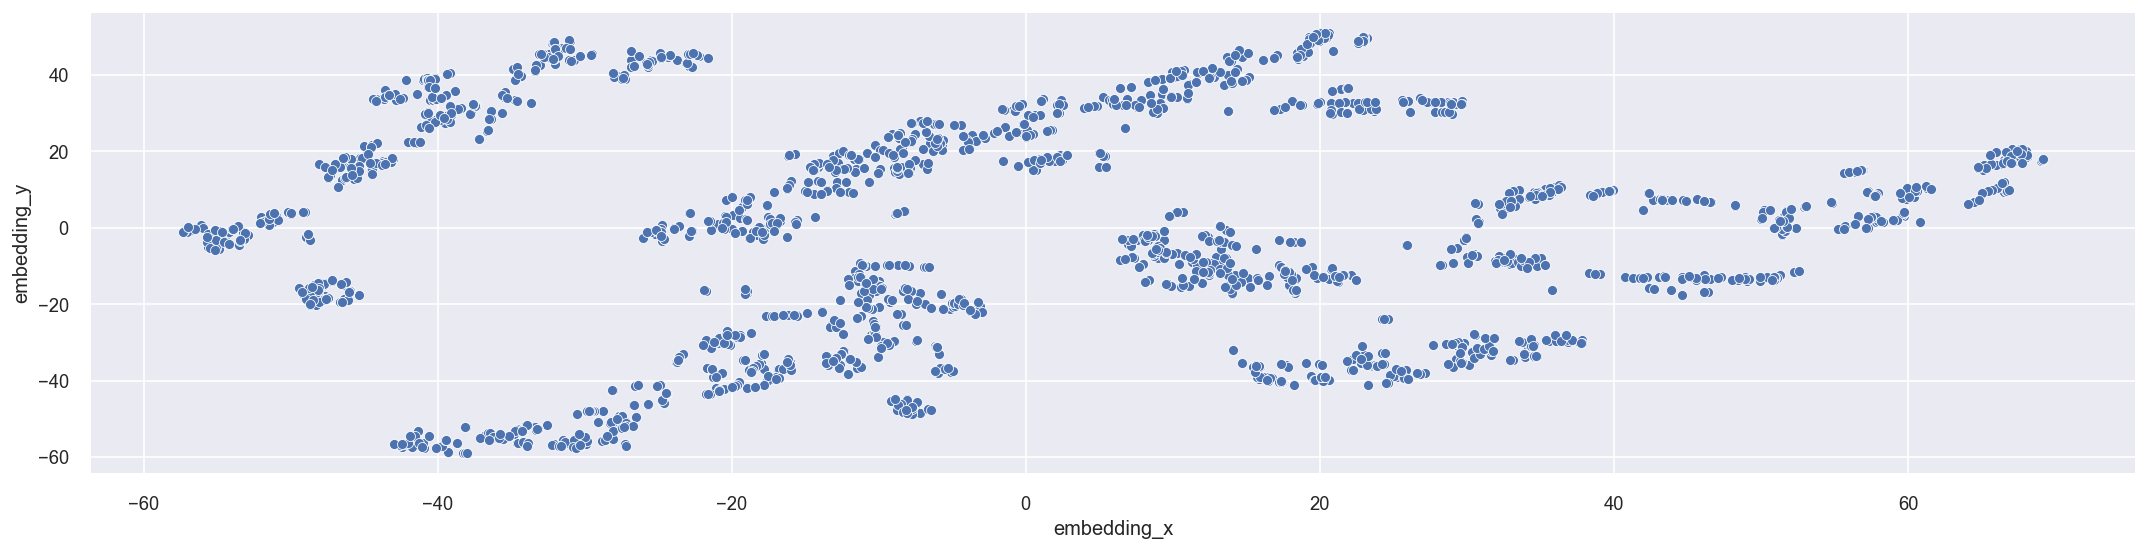

In [338]:
plt.figure(figsize = (22, 5))
reducer = TSNE(n_components = 2, random_state = 42) # n_components = 2 significa reduzir para 2d
embedding = reducer.fit_transform(df_folhas)

#Embedding
df_folhas['embedding_x'] = embedding[:, 0]
df_folhas['embedding_y'] = embedding[:, 1]

# Plotando o t_SNE
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_folhas);

* O gráfico do t-SNE (após RandomForestRegressor) mostra grupos mais densos e mais separados do que o UMAP. Isso facilita a identificação de limites claros entre os clusters, também neste gráfico, é possivel identificar visualmente cerca de 5 clusters bem isolados.

# 7. (Algoritmos de Ml) Passo 7: Implementar os modelos de machine learning

### 7.1 Dados do originais (sem redução de dimensionalidade)

In [339]:
clusters = range(2, 11) # 2 a 11 clusters

df_scores = pd.DataFrame(index = ['KMeans', 'GMM', 'HC'], columns = clusters)

# K-means
for k in clusters:
    modelo = KMeans(n_clusters = k, random_state = 42)
    labels = modelo.fit_predict(df63)
    sil = silhouette_score(df63, labels)
    df_scores.loc['KMeans', k] = sil

# GMM
for k in clusters:
    modelo = GaussianMixture(n_components = k, covariance_type = 'full', random_state = 42)
    labels = modelo.fit_predict(df63)
    sil = silhouette_score(df63, labels)
    df_scores.loc['GMM', k] = sil

# HIERÁRQUICO
for k in clusters:
    modelo = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
    labels = modelo.fit_predict(df63)
    sil = silhouette_score(df63, labels)
    df_scores.loc['HC', k] = sil

# RESULTADO FINAL
df_scores = df_scores.astype(float)
df_scores.style.highlight_max(color = 'red', axis = 1)

,2,3,4,5,6,7,8,9,10
KMeans,0.293095,0.218371,0.163607,0.120482,0.109842,0.089141,0.111113,0.087956,0.084352
GMM,0.105131,0.045820,0.033301,-0.015255,-0.081657,-0.085094,-0.016558,-0.015942,-0.092728
HC,0.260006,0.196467,0.145282,0.093178,0.095294,0.082311,0.083420,0.080086,0.073079


 * A análise inicial foi conduzida sem a aplicação de técnicas de redução de dimensionalidade. Nessa configuração, os resultados dos coeficientes de Silhouette mostraram desempenho relativamente baixo para todos os algoritmos avaliados. O K-Means apresentou valores entre 0,29 (k=2) e 0,08 (k=10), enquanto GMM e HC mostraram desempenhos ainda mais modestos. Ou seja, sem redução de dimensionalidade, os algoritmos tiveram dificuldade de distinguir grupos de forma consistente.

### 7.2 Dados do originais (com redução de dimensionalidade por PCA)

In [340]:
clusters = range(2, 11) # 2 a 11 clusters

df_scores = pd.DataFrame(index = ['KMeans', 'GMM', 'HC'], columns = clusters)

# K-means
for k in clusters:
    modelo = KMeans(n_clusters = k, random_state = 42)
    labels = modelo.fit_predict(df_pca)
    sil = silhouette_score(df_pca, labels)
    df_scores.loc['KMeans', k] = sil

# GMM
for k in clusters:
    modelo = GaussianMixture(n_components = k, covariance_type = 'full', random_state = 42)
    labels = modelo.fit_predict(df_pca)
    sil = silhouette_score(df_pca, labels)
    df_scores.loc['GMM', k] = sil

# HIERÁRQUICO
for k in clusters:
    modelo = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
    labels = modelo.fit_predict(df_pca)
    sil = silhouette_score(df_pca, labels)
    df_scores.loc['HC', k] = sil

# RESULTADO FINAL
df_scores = df_scores.astype(float)
df_scores.style.highlight_max(color = 'red', axis = 1)


,2,3,4,5,6,7,8,9,10
KMeans,0.520307,0.439976,0.373822,0.407129,0.409135,0.407041,0.359224,0.370046,0.360093
GMM,0.496612,0.413896,0.353069,0.367468,0.332203,0.303462,0.279443,0.278574,0.252293
HC,0.479564,0.427558,0.373954,0.349719,0.375244,0.342361,0.314659,0.296106,0.286976


* O Silhouette Score é uma métrica utilizada para avaliar a qualidade de uma clusterização, ou seja, ele mede o quão bem cada ponto está agrupado com os pontos do seu próprio cluster e separado dos pontos dos outros clusters:
    * O valor varia de -1 a 1, onde:
        * +1 → clusters muito bem definidos e bem separados
        * 0 → clusters sobrepostos ou mal separados
        * valores negativos → pontos provavelmente foram atribuídos ao cluster errado

        Silhouette Score	Interpretação

        Maior 0.70	        Clusterização excelente (raríssimo em dados reais)
        
        0.50–0.70	        Clusterização boa
        
        0.30–0.50	        Clusterização aceitável / fraca, mas com alguma estrutura
        
        0.20–0.30       	Estrutura muito fraca, clusters sobrepostos
        
        Menor 0.20          Clusters praticamente inexistentes / ruído

* O baixo silhouette score (0,52) obtido com PCA utilizando somente 2 componentes, os quais explicam apenas 62% da variância total, indica que a técnica pode não estar capturando adequadamente a estrutura dos dados.

    Esta limitação sugere que os clusters possuem formatos complexos, potencialmente não-esféricos ou não-lineares, que não se alinham com as direções de máxima variância identificadas pelo PCA. Portanto, serão implementadas técnicas alternativas de redução dimensional mais adequadas para preservar essas estruturas complexas durante a clusterização.

### 7.3 Dados do originais (com redução de dimensionalidade por RandomForestRegressor)

In [341]:
clusters = range(2, 11) # 2 a 11 clusters

df_folhas.columns = df_folhas.columns.astype(str)
df_scores = pd.DataFrame(index = ['KMeans', 'GMM', 'HC'], columns = clusters)

# K-means
for k in clusters:
    modelo = KMeans(n_clusters = k, random_state = 42)
    labels = modelo.fit_predict(df_folhas)
    sil = silhouette_score(df_folhas, labels)
    df_scores.loc['KMeans', k] = sil

# GMM
for k in clusters:
    modelo = GaussianMixture(n_components = k, covariance_type = 'full', random_state = 42)
    labels = modelo.fit_predict(df_folhas)
    sil = silhouette_score(df_folhas, labels)
    df_scores.loc['GMM', k] = sil

# HIERÁRQUICO
for k in clusters:
    modelo = AgglomerativeClustering(n_clusters = k, linkage = 'ward')
    labels = modelo.fit_predict(df_folhas)
    sil = silhouette_score(df_folhas, labels)
    df_scores.loc['HC', k] = sil

# RESULTADO FINAL
df_scores = df_scores.astype(float)
df_scores.style.highlight_max(color = 'red', axis = 1)

,2,3,4,5,6,7,8,9,10
KMeans,0.610652,0.551755,0.498373,0.460019,0.439279,0.417348,0.401386,0.373085,0.372622
GMM,0.606802,0.544319,0.497204,0.458535,0.438378,0.415628,0.399790,0.372634,0.372315
HC,0.587004,0.506255,0.469352,0.441148,0.411849,0.384824,0.364391,0.342356,0.335939


* A variável 'monetary' foi utilizada como target em modelos baseados em árvores de decisão, com o objetivo de identificar quais atributos exercem maior influência sobre o valor monetário dos clientes. A partir dessa análise preliminar, foram aplicados os algoritmos de clusterização K-Means, Gaussian Mixture Models (GMM) e Hierarchical Clustering (HC) para explorar a estrutura natural dos dados. 

    Entre os métodos avaliados, o K-Means apresentou os maiores valores de Silhouette na maior parte das configurações testadas (0,61), indicando melhor separação entre os grupos formados. A convergência dos resultados sugere que as segmentações mais adequadas encontram-se entre 2 e 3 clusters, sendo k = 3 a opção mais equilibrada para aplicação em contexto de negócio.

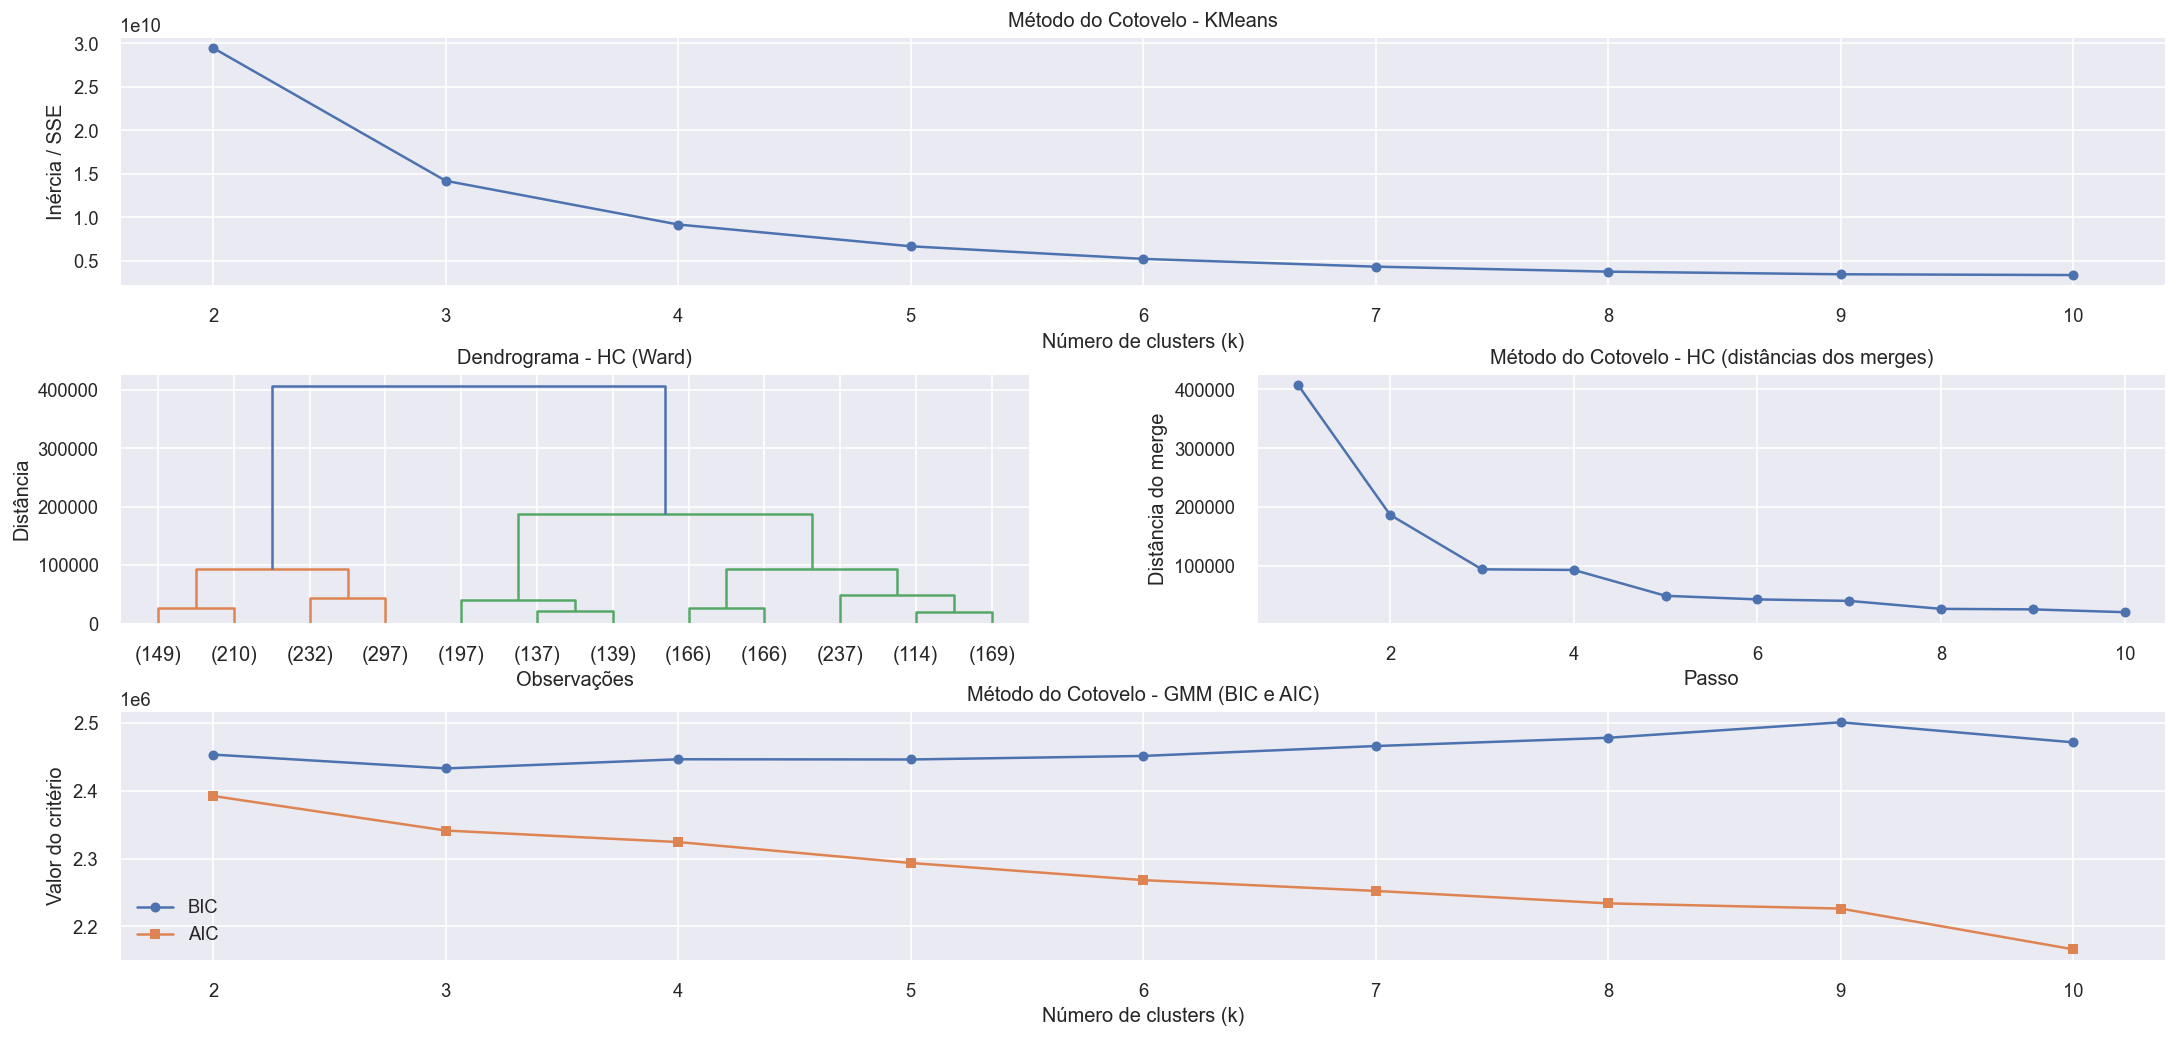

In [342]:
plt.figure(figsize = (22, 10))
grid = plt.GridSpec(3, 2, hspace = 0.35, wspace = 0.25)

# MÉTODO DO COTOVELO PARA KMEANS
ax1 = plt.subplot(grid[0, :])

K = range(2, 11)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(df_folhas)
    inertias.append(kmeans.inertia_)

ax1.plot(K, inertias, marker = 'o')
ax1.set_xlabel("Número de clusters (k)")
ax1.set_ylabel("Inércia / SSE")
ax1.set_title("Método do Cotovelo - KMeans")
ax1.grid(True)

# HIERARCHICAL – DENDROGRAMA
ax3 = plt.subplot(grid[1, 0])

Z = linkage(df_folhas, method = 'ward')
dendrogram(Z, truncate_mode = 'lastp', p = 12, show_leaf_counts = True)

ax3.set_title("Dendrograma - HC (Ward)")
ax3.set_xlabel("Observações")
ax3.set_ylabel("Distância")
ax3.grid(True)

# HIERARCHICAL – COTOVELO PELAS DISTÂNCIAS DOS MERGES
ax4 = plt.subplot(grid[1, 1])

last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

ax4.plot(idxs, last_rev, marker = 'o')
ax4.set_title("Método do Cotovelo - HC (distâncias dos merges)")
ax4.set_xlabel("Passo")
ax4.set_ylabel("Distância do merge")
ax4.grid(True)

# GMM – BIC E AIC
ax2 = plt.subplot(grid[2, :])

bics = []
aics = []

for k in K:
    gmm = GaussianMixture(n_components = k, random_state = 42)
    gmm.fit(df_folhas)
    bics.append(gmm.bic(df_folhas))
    aics.append(gmm.aic(df_folhas))

ax2.plot(K, bics, marker = 'o', label = 'BIC')
ax2.plot(K, aics, marker = 's', label = 'AIC')
ax2.set_xlabel("Número de clusters (k)")
ax2.set_ylabel("Valor do critério")
ax2.set_title("Método do Cotovelo - GMM (BIC e AIC)")
ax2.legend()
ax2.grid(True)
plt.show();

* Para definir a quantidade ideal de clusters, foram utilizadas três abordagens complementares: K-Means, Hierarchical Clustering (HC) e Gaussian Mixture Models (GMM). A convergência entre esses métodos fortalece a escolha final.
    * K-Means – Método do Cotovelo (SSE/Inércia)
    O gráfico de inércia apresenta uma queda acentuada entre k = 2 e k = 3, e uma redução moderada entre k = 3 e k = 4, a partir de k = 4, a curva se estabiliza, indicando que o ganho adicional de segmentação é pouco significativo, ou seja, o 'cotovelo' ocorre em k = 3, sugerindo que três clusters capturam de forma equilibrada a estrutura dos dados.
    * Hierarchical Clustering (Ward) – Dendrograma
    O dendrograma mostra um salto vertical expressivo ao juntar os grandes grupos finais, especialmente ao passar de 3 para 2 clusters, indicando que a divisão natural dos dados ocorre antes dessa união tardia, ou seja, em três agrupamentos principais, evidenciando que a separação mais consistente está em 3 clusters, pois unir além disso exige juntar grupos muito distantes.
    * HC – Distância dos merges (método do cotovelo)
    O gráfico das distâncias dos merges revela que valores muito altos nos primeiros passos (clusters muito diferentes sendo unidos), mostrando uma estabilização clara após o 3º merge, mostrando que a queda brusca seguida de estabilização reforça que 3 clusters é o ponto de maior distinção natural.
    * GMM – Critérios BIC e AIC
    O AIC diminui continuamente, o que é esperado, mas tende a superestimar k, já o BIC, que penaliza modelos complexos, apresenta seu menor valor significativo entre k = 2 e k = 3, com tendência mais forte para k = 3, em outras palavras, o BIC identifica k = 3 como o modelo mais parcimonioso e estável.

* A conclusão de todos os métodos utilizados: K-Means, Hierarchical (Ward) e GMM-BIC, convergem consistentemente para 3 clusters como a melhor solução de segmentação.

# 8. (Algoritmos de Ml) Passo 8: Implementar os modelos de machine learning

### 8.1 Algoritmo K-means

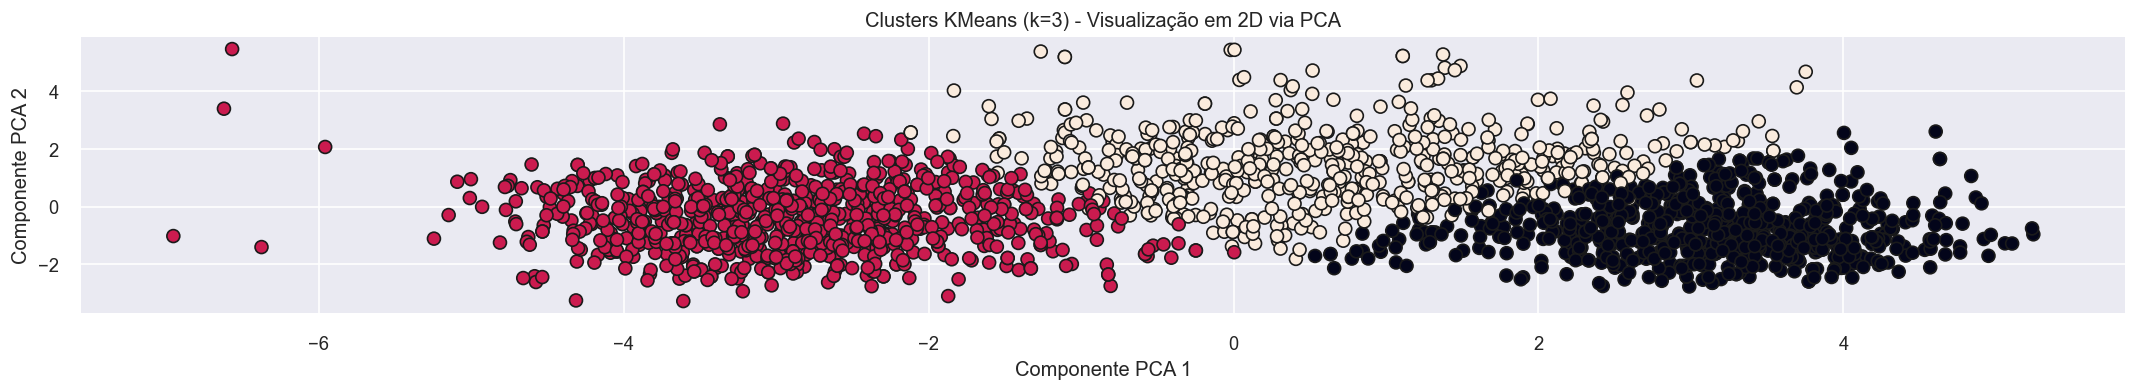

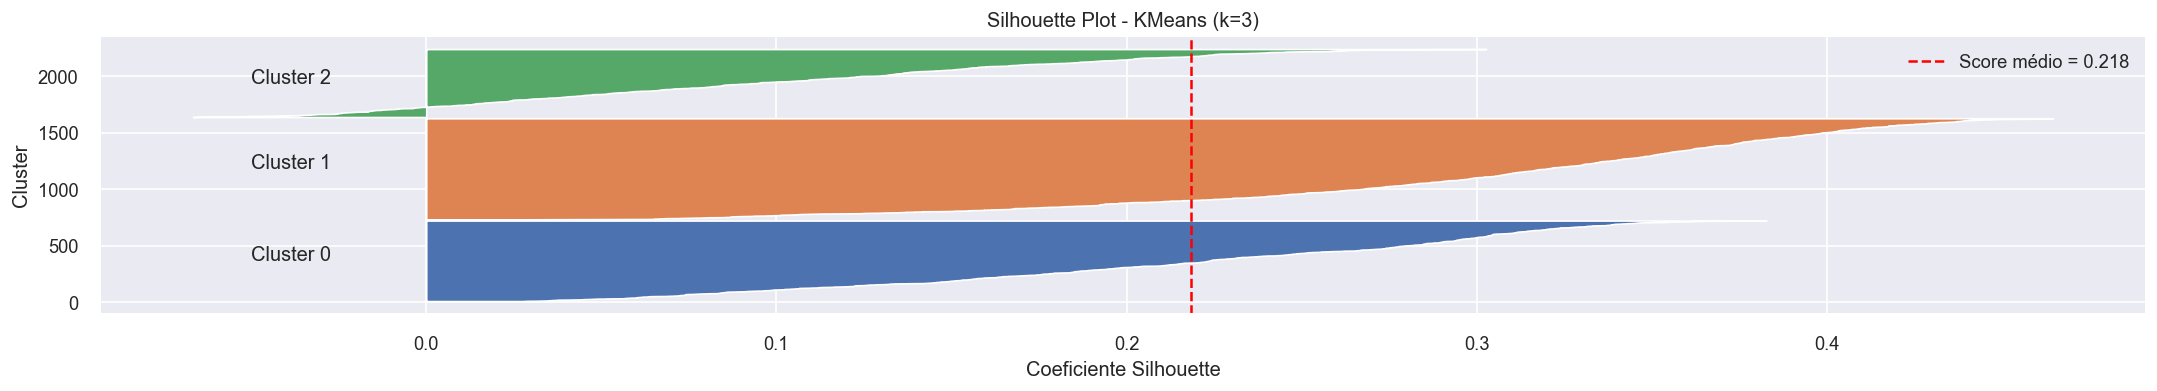

In [343]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
labels = kmeans.fit_predict(df63)

# Aplicando PCA para reduzir df63 para 2 componentes e visualizar em 2D
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(df63)

# Gerando o gráfico dos clusters em 2D
plt.figure(figsize = (22, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = labels, s = 60, edgecolor = 'k')
plt.title("Clusters KMeans (k=3) - Visualização em 2D via PCA")
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.grid(True)
plt.show()

# Plotando a métrica Silhouette Score
sil_score = silhouette_score(df63, labels)
sample_silhouette_values = silhouette_samples(df63, labels)
y_lower = 10

plt.figure(figsize = (22, 3))

for i in range(3):
    ith_values = sample_silhouette_values[labels == i]
    ith_values.sort()
    
    size = ith_values.shape[0]
    y_upper = y_lower + size

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_values)
    plt.text(-0.05, y_lower + size / 2, f"Cluster {i}")
    
    y_lower = y_upper + 10

plt.axvline(x = sil_score, color = "red", linestyle = "--", label = f"Score médio = {sil_score:.3f}")
plt.xlabel("Coeficiente Silhouette")
plt.ylabel("Cluster")
plt.title("Silhouette Plot - KMeans (k=3)")
plt.legend()
plt.grid(True)
plt.show();

* A análise combinando a projeção em PCA (para fins de visualização) e o coeficiente Silhouette indica que o algoritmo KMeans com k = 3 oferece uma segmentação estável, coerente e compatível com a estrutura encontrada nos dados. Observa-se que o cluster central apresenta a melhor coesão interna, enquanto os outros dois grupos revelam comportamentos distintos, um mais disperso e outro mais concentrado, sugerindo padrões bem diferenciados entre os clientes.

    Apesar de alguma sobreposição entre regiões de fronteira, o modelo KMeans consegue identificar três perfis consistentes:

    * Cluster 1: grupo mais bem definido, alta coesão e comportamento homogêneo.
    * Cluster 0: grupo intermediário, com características mais mistas, refletindo maior variação interna.
    * Cluster 2: grupo mais disperso, apresentando maior heterogeneidade e proximidade entre regiões de fronteira.

    Essa estrutura é comum em bases de comportamento de clientes, onde a segmentação tende a refletir gradientes contínuos em vez de limites rígidos. Ainda assim, a separação obtida fornece insights relevantes para estratégias de marketing, atendimento e priorização comercial.

# 9. (Algoritmos de Ml) Passo 9: Análise dos clusters

### 9.1 Adicionar a coluna com os clusters 

In [344]:
# Para estornar as transformações dos dados, optou-se em pegar um dataset anterior as transformações e remoções, ou seja, com os dados originais, neste caso o dataset df4
df9 = df4.copy()
df9['cluster'] = labels

In [345]:
df9.head(3)

,id,ano_nascimento,educacao,estado_civil,renda,qtde_criancas,qtde_adolescentes,data_cadastro,dias_ultima_compra,valor_gasto_vinhos,valor_gasto_frutas,valor_gasto_carnes,valor_gasto_peixes,valor_gasto_doces,valor_gasto_premium,qtde_compras_descontos,qtde_compras_website,qtde_compras_catalogo,qtde_compras_loja_fisica,qtde_visitas_website,aceitou_campanha_1,aceitou_campanha_2,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,respondeu_campanha,registrou_reclamaçao,educacao_agrupado,estado_civil_agrupado,idade,dependentes,recency,frequency,monetary,cluster
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,1,0,Graduation,Single,68,0,58,25,1617,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,Graduation,Single,71,2,38,6,27,1
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,Graduation,Married,60,0,26,21,776,0


### 9.2 Identificar os clusters

### 9.2.1 Estatísticas numéricas por Cluster

In [346]:
# Estatísticas descritivas por cluster
cluster_profile = df9.groupby('cluster').mean(numeric_only = True).round(2)
cluster_profile

,ano_nascimento,renda,qtde_criancas,qtde_adolescentes,dias_ultima_compra,valor_gasto_vinhos,valor_gasto_frutas,valor_gasto_carnes,valor_gasto_peixes,valor_gasto_doces,valor_gasto_premium,qtde_compras_descontos,qtde_compras_website,qtde_compras_catalogo,qtde_compras_loja_fisica,qtde_visitas_website,aceitou_campanha_1,aceitou_campanha_2,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,respondeu_campanha,registrou_reclamaçao,idade,dependentes,recency,frequency,monetary
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1967.95,73294.14,0.04,0.29,49.50,576.86,63.66,398.34,91.63,65.20,74.97,1.47,5.31,5.61,8.51,3.09,0.16,0.02,0.08,0.10,0.20,0.23,0.01,57.05,0.33,49.50,20.90,1270.65
1,1971.89,33262.80,0.79,0.44,48.83,29.08,3.95,16.35,5.44,4.06,12.53,1.87,1.81,0.41,2.99,6.50,0.00,0.00,0.07,0.01,0.00,0.09,0.01,53.11,1.23,48.83,7.08,71.42
2,1965.65,55495.98,0.40,0.86,48.68,393.65,15.36,116.79,21.55,15.98,53.76,4.02,6.03,2.55,6.78,6.22,0.04,0.02,0.08,0.13,0.03,0.15,0.00,59.35,1.26,48.68,19.39,617.09


### 9.2.2 Contagem de variáveis categóricas por Cluster

In [347]:
# Frequências de variáveis categóricas
categorical_vars = ['educacao_agrupado', 'estado_civil_agrupado']

for col in categorical_vars:
    display(df9.groupby('cluster')[col].value_counts(normalize = True).mul(100).round(1))
    print('\n')

cluster  educacao_agrupado
0        Graduation           56.0
         PhD                  20.2
         Master               14.4
         2n Cycle              9.4
1        Graduation           48.2
         PhD                  19.2
         Master               16.1
         2n Cycle             10.7
         Basic                 5.8
2        Graduation           47.1
         PhD                  27.2
         Master               19.6
         2n Cycle              5.8
         Basic                 0.3
Name: proportion, dtype: float64

cluster  estado_civil_agrupado
0        Married                  63.4
         Single                   22.5
         Divorced                  9.7
         Widow                     4.1
         Unknown                   0.3
1        Married                  65.2
         Single                   23.0
         Divorced                  9.7
         Widow                     2.1
2        Married                  65.0
         Single                   17.9
         Divorced                 12.4
         Widow                     4.6
Name: proportion, dtype: float64

### 9.2.3 Perfil RFM por Cluster

In [348]:
df9.groupby('cluster')[['idade', 'recency', 'frequency', 'monetary']].mean().round(2)

,idade,recency,frequency,monetary
cluster,,,,
0,57.05,49.50,20.90,1270.65
1,53.11,48.83,7.08,71.42
2,59.35,48.68,19.39,617.09


### 9.2.4 Padrões de consumo (valores gastos) por cluster

In [349]:
gastos = ['valor_gasto_vinhos',
          'valor_gasto_frutas',
          'valor_gasto_carnes',
          'valor_gasto_peixes',
          'valor_gasto_doces',
          'valor_gasto_premium']

df9.groupby('cluster')[gastos].mean().round(1)

,valor_gasto_vinhos,valor_gasto_frutas,valor_gasto_carnes,valor_gasto_peixes,valor_gasto_doces,valor_gasto_premium
cluster,,,,,,
0,576.9,63.7,398.3,91.6,65.2,75.0
1,29.1,3.9,16.4,5.4,4.1,12.5
2,393.6,15.4,116.8,21.6,16.0,53.8


### 9.2.5 Comportamento de compra por cluster

In [350]:
comportamento = ['qtde_compras_descontos',
                 'qtde_compras_website',
                 'qtde_compras_catalogo',
                 'qtde_compras_loja_fisica',
                 'qtde_visitas_website']

df9.groupby('cluster')[comportamento].mean().round(2)

,qtde_compras_descontos,qtde_compras_website,qtde_compras_catalogo,qtde_compras_loja_fisica,qtde_visitas_website
cluster,,,,,
0,1.47,5.31,5.61,8.51,3.09
1,1.87,1.81,0.41,2.99,6.50
2,4.02,6.03,2.55,6.78,6.22


### 9.2.6 Conversão em campanhas por cluster

In [351]:
campanhas = ['aceitou_campanha_1',
             'aceitou_campanha_2',
             'aceitou_campanha_3',
             'aceitou_campanha_4',
             'aceitou_campanha_5',
             'respondeu_campanha']

df9.groupby('cluster')[campanhas].mean().round(3)

,aceitou_campanha_1,aceitou_campanha_2,aceitou_campanha_3,aceitou_campanha_4,aceitou_campanha_5,respondeu_campanha
cluster,,,,,,
0,0.164,0.021,0.076,0.101,0.203,0.232
1,0.001,0.002,0.069,0.012,0.000,0.087
2,0.040,0.022,0.078,0.134,0.027,0.148


### 9.3 Caracteristicas dos clusters

### Cluster 01: (Clientes Premium de Alto Valor) 

* Este é o grupo mais valioso da base, com maior gasto total e comportamento de compra mais consistente. Este cluster representa clientes de alto poder aquisitivo, maduros, fiéis e com alto valor para a empresa. Eles respondem bem a campanhas e realizam compras frequentes e de produtos de maior ticket.

* Características principais:
    * Renda: Alta com média de R$ 73.294 (a maior entre os grupos)
    * Idade: Média de 57 anos
    * Gasto: Médio de R$ 1.270,65
    * Consumo: Elevado de vinhos, carnes e produtos premium
    * Frequência de compras: Alta com média de 20,9 compras
    * Dependentes: Baixa presença de dependentes
    * Engajamento: Maior engajamento com campanhas
    * Canal de compra: Multicanal, especialmente loja física, catálogo e website

**Recomendação:** Para estes clientes, deve ter um o foco maior na retenção, programas VIP e campanhas exclusivas, pois representa a maior fatia de receita.

### Cluster 02: (Clientes de Baixo Valor e Baixo Engajamento) 

* Grupo com menor renda, baixo gasto e reduzido envolvimento com campanhas da empresa. Este cluster representa clientes sensíveis a preço, pouco fiéis e de baixo LTV. São esporádicos e dificilmente respondem a campanhas.

* Características principais:
    * Renda: Baixa com média de R$ 33.262
    * Idade: Média de 53 anos
    * Gasto: Médio de R$ 71,42
    * Consumo: Menor consumo em todas as categorias
    * Frequência de compra: Baixa com média de 7,08 compras
    * Dependentes: Maior número de dependentes
    * Engajamento: Quase nulo com campanhas
    * Canal de compra: Presenciais e poucas compras online

**Recomendação:** Para este grupo, seriam necessárias mais ações de ativação e reengajamento, mas possui baixo potencial de monetização.

### Cluster 03: (Clientes de Consumo Moderado e Perfil Tradicional)

* Grupo intermediário, com poder aquisitivo médio e comportamento de compra consistente, porém menos intenso que o cluster premium. Este cluster é composto por clientes estáveis, com boa renda e comportamento relativamente previsível. Apesar de não serem tão valiosos quanto o cluster 0, apresentam um bom potencial para campanhas personalizadas.

* Características principais:
    * Renda: Moderada com média de R$ 55.496
    * Idade: Média de 59 anos
    * Gasto: Moderado com média de R$ 617,09
    * Consumo: Preferencialmente vinhos e carnes
    * Frequência de compras: Moderada com média de 19,39 compras
    * Dependentes: Maior quantidade de adolescentes como dependentes
    * Engajamento: Moderada às campanhas
    * Canal de compra: Boa atividade multicanal

**Recomendação:** Para estes consumidores demonstram uma base sólida para upsell, cross-sell e campanhas personalizadas, especialmente em categorias premium de menor consumo.

# 10. (Modelo em produção) Passo 10: Modelo em produção

### 10.1 Criar classe do projeto (salvar como script.py) (onde são feitas todos os tratamentos

e as transformações dos dados)

### 10.2 Criar API (salvar como api_handler.py)

### 10.3 Testar a API

#### 10.3.1 Predição